#### Necessary Imports

In [ ]:
# Import necessary libraries and modules
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Establish Paths

In [ ]:
#Connect to Drive Folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Establish path
# Replace '------' with the path such that "ITCS_4152_5152_assignment5" is your working directory
%cd '/content/drive/My Drive/CapstoneProject/models/EmotionRecognitionModels/DeepLearningModel'

/content/drive/My Drive/CapstoneProject/models/EmotionRecognitionModels/DeepLearningModel


##Load Training Data

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)
class_names = [name[20:] for name in glob.glob('./data/images/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=True, zero_centered=False):
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(float)/255*2-1)


    # Data Augmentation
    if augment:
        #pass

        print(len(data))
        for i in range(len(data)):
          img = data[i]
          newImglr = np.fliplr(img)
          newImgud = np.flipud(img)
          data.append(newImglr)
          data.append(newImgud)
        print(len(data))


    # Data Normalization

    if zero_centered:
        # Calculate mean and standard deviation for all images
        data_array = np.array(data)
        mean = data_array.mean()
        std = data_array.std()

        # Normalize each image
        for i in range(len(data)):
            img = data[i]
            img = (img - mean) / std
            data[i] = img


    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []

        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels

    return zip(batch_data, batch_labels)

class_names: {0: 'angry', 1: 'fear', 2: 'happy', 3: 'sad'} 


#### Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Load data into size (64, 64)
img_size = (64, 64)
batch_size = 64  # Training sample number per batch

# Load all data from the train folder
all_data = list(load_dataset('./data/images/train/', img_size, batch_size=batch_size, shuffle=True))
all_num = len(all_data)

# Split the data into training and testing sets (80/20 split)
trainloader, testloader = train_test_split(all_data, test_size=0.2, random_state=42)

train_num = len(trainloader)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

test_num = len(testloader)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Finish loading 136 minibatches (batch_size=64) of training samples.
Finish loading 35 minibatches (batch_size=64) of testing samples.


#### Example Input

fear


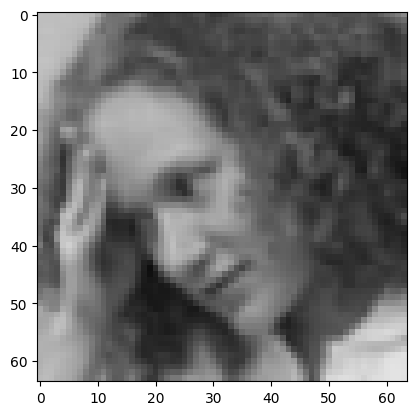

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = (npimg * 255).astype(np.uint8)


    if npimg.shape[0] == 1:
        npimg = np.stack([npimg[0]] * 3, axis=-1)

    npimg = npimg.transpose((1, 2, 0))  # Transpose to (H, W, C) for display
    npimg = cv2.cvtColor(npimg, cv2.COLOR_BGR2RGB)
    plt.imshow(npimg)
    plt.show()

num_images = len(trainloader)
random_index = np.random.randint(num_images)


img, label = trainloader[0][0][random_index], trainloader[0][1][random_index]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Model Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import time

def trainModel(net, trainloader, train_option, testloader=None):
    loss_func = nn.CrossEntropyLoss()  # Cross-Entropy Loss for multi-class classification
    lr = train_option['lr']
    epoch = train_option['epoch']
    device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
    log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
    eval_epoch = 1

    if 'optimizer' in train_option.keys():
        optimizer = train_option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    if device == 'gpu':
        net = net.cuda()

    iters = 0
    running_loss = 0.0
    for ep in range(epoch):
        net.train()
        for iter, (x, y) in enumerate(trainloader):
            iters += 1
            batch_x = Variable(x).float()
            batch_y = Variable(y).long()  # Use long for multi-class classification

            if device == 'gpu':
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()

            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
            if iter % log_iter == 0:
                print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep + 1, iter, time_lapse, loss.item(), running_loss / iters))

        if testloader is not None and ep % eval_epoch == 0:
            evalModel(net, testloader)


## Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Model evaluation function with ROC (modified for multi-class classification)
def evalModel(net, testloader):
    correct = 0
    total = 0
    device = 'cuda' if next(net.parameters()).is_cuda else 'cpu'
    net.eval()

    true_labels = []
    predicted_scores = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if device == 'cuda':
                images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_scores.extend(outputs.cpu().numpy())

    accuracy = correct / total
    print('Accuracy: {:.4f}'.format(accuracy))

    true_labels = np.array(true_labels)
    predicted_scores = np.array(predicted_scores)

    # Compute ROC curve and AUC score for each class
    lb = LabelBinarizer()
    true_labels_bin = lb.fit_transform(true_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(lb.classes_)):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_scores[:, i])
        roc_auc[i] = roc_auc_score(true_labels_bin[:, i], predicted_scores[:, i])

    # Compute micro-average ROC curve and AUC score
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), predicted_scores.ravel())
    roc_auc["micro"] = roc_auc_score(true_labels_bin, predicted_scores, average="micro")

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc["micro"]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


## Model Architecture

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3985 | Average Loss: 1.3985 
Epoch: 1 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.2660 | Average Loss: 1.3016 
Epoch: 1 | Iter:   40 | Time: 00:00:02 | Train Loss: 1.2885 | Average Loss: 1.2911 
Epoch: 1 | Iter:   60 | Time: 00:00:03 | Train Loss: 1.2051 | Average Loss: 1.2876 
Epoch: 1 | Iter:   80 | Time: 00:00:04 | Train Loss: 1.3091 | Average Loss: 1.2817 
Epoch: 1 | Iter:  100 | Time: 00:00:05 | Train Loss: 1.3019 | Average Loss: 1.2817 
Epoch: 1 | Iter:  120 | Time: 00:00:06 | Train Loss: 1.2713 | Average Loss: 1.2818 
Accuracy: 0.3790


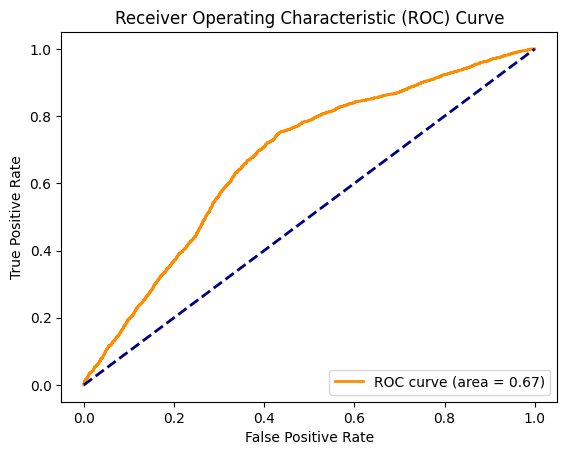

Epoch: 2 | Iter:    0 | Time: 00:00:07 | Train Loss: 1.3278 | Average Loss: 1.2835 
Epoch: 2 | Iter:   20 | Time: 00:00:08 | Train Loss: 1.2675 | Average Loss: 1.2812 
Epoch: 2 | Iter:   40 | Time: 00:00:09 | Train Loss: 1.2465 | Average Loss: 1.2779 
Epoch: 2 | Iter:   60 | Time: 00:00:10 | Train Loss: 1.1829 | Average Loss: 1.2761 
Epoch: 2 | Iter:   80 | Time: 00:00:11 | Train Loss: 1.3258 | Average Loss: 1.2744 
Epoch: 2 | Iter:  100 | Time: 00:00:12 | Train Loss: 1.3018 | Average Loss: 1.2741 
Epoch: 2 | Iter:  120 | Time: 00:00:13 | Train Loss: 1.2645 | Average Loss: 1.2737 
Accuracy: 0.3795


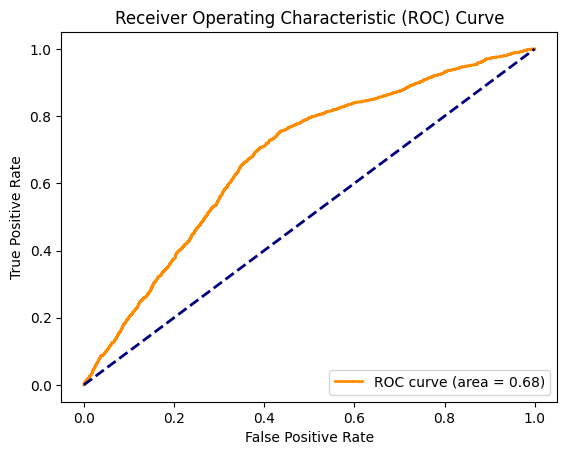

Epoch: 3 | Iter:    0 | Time: 00:00:15 | Train Loss: 1.3288 | Average Loss: 1.2743 
Epoch: 3 | Iter:   20 | Time: 00:00:16 | Train Loss: 1.2663 | Average Loss: 1.2734 
Epoch: 3 | Iter:   40 | Time: 00:00:17 | Train Loss: 1.2530 | Average Loss: 1.2715 
Epoch: 3 | Iter:   60 | Time: 00:00:18 | Train Loss: 1.1773 | Average Loss: 1.2706 
Epoch: 3 | Iter:   80 | Time: 00:00:19 | Train Loss: 1.2938 | Average Loss: 1.2691 
Epoch: 3 | Iter:  100 | Time: 00:00:20 | Train Loss: 1.2922 | Average Loss: 1.2685 
Epoch: 3 | Iter:  120 | Time: 00:00:21 | Train Loss: 1.2516 | Average Loss: 1.2676 
Accuracy: 0.4103


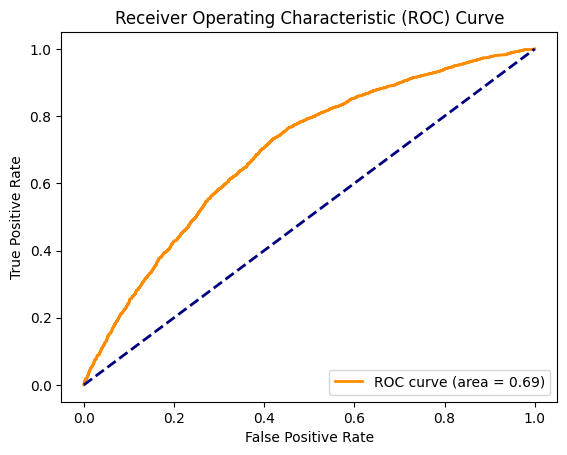

Epoch: 4 | Iter:    0 | Time: 00:00:22 | Train Loss: 1.2722 | Average Loss: 1.2675 
Epoch: 4 | Iter:   20 | Time: 00:00:23 | Train Loss: 1.2384 | Average Loss: 1.2660 
Epoch: 4 | Iter:   40 | Time: 00:00:24 | Train Loss: 1.2841 | Average Loss: 1.2651 
Epoch: 4 | Iter:   60 | Time: 00:00:25 | Train Loss: 1.1746 | Average Loss: 1.2641 
Epoch: 4 | Iter:   80 | Time: 00:00:26 | Train Loss: 1.2622 | Average Loss: 1.2622 
Epoch: 4 | Iter:  100 | Time: 00:00:27 | Train Loss: 1.2448 | Average Loss: 1.2613 
Epoch: 4 | Iter:  120 | Time: 00:00:28 | Train Loss: 1.2290 | Average Loss: 1.2605 
Accuracy: 0.4223


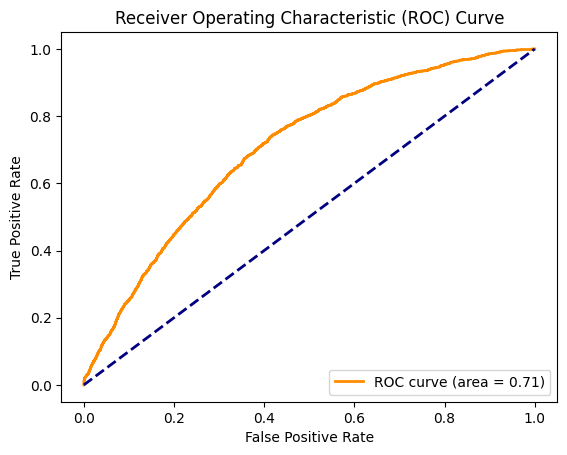

Epoch: 5 | Iter:    0 | Time: 00:00:30 | Train Loss: 1.2751 | Average Loss: 1.2601 
Epoch: 5 | Iter:   20 | Time: 00:00:31 | Train Loss: 1.2456 | Average Loss: 1.2585 
Epoch: 5 | Iter:   40 | Time: 00:00:32 | Train Loss: 1.2103 | Average Loss: 1.2578 
Epoch: 5 | Iter:   60 | Time: 00:00:33 | Train Loss: 1.1308 | Average Loss: 1.2570 
Epoch: 5 | Iter:   80 | Time: 00:00:34 | Train Loss: 1.2522 | Average Loss: 1.2556 
Epoch: 5 | Iter:  100 | Time: 00:00:35 | Train Loss: 1.2039 | Average Loss: 1.2544 
Epoch: 5 | Iter:  120 | Time: 00:00:36 | Train Loss: 1.1975 | Average Loss: 1.2529 
Accuracy: 0.4527


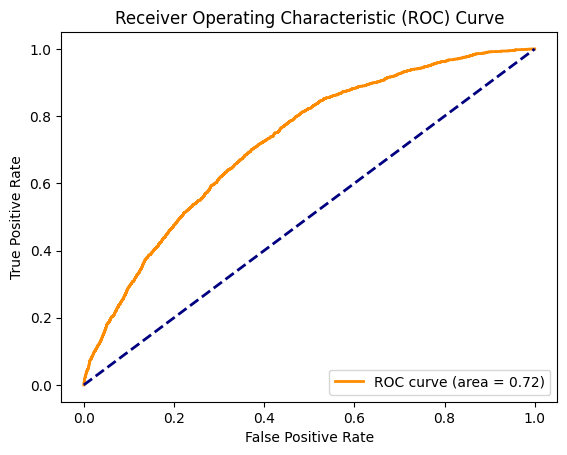

Epoch: 6 | Iter:    0 | Time: 00:00:37 | Train Loss: 1.2747 | Average Loss: 1.2517 
Epoch: 6 | Iter:   20 | Time: 00:00:38 | Train Loss: 1.2093 | Average Loss: 1.2499 
Epoch: 6 | Iter:   40 | Time: 00:00:39 | Train Loss: 1.2047 | Average Loss: 1.2483 
Epoch: 6 | Iter:   60 | Time: 00:00:40 | Train Loss: 1.0940 | Average Loss: 1.2468 
Epoch: 6 | Iter:   80 | Time: 00:00:41 | Train Loss: 1.1443 | Average Loss: 1.2450 
Epoch: 6 | Iter:  100 | Time: 00:00:42 | Train Loss: 1.1753 | Average Loss: 1.2435 
Epoch: 6 | Iter:  120 | Time: 00:00:43 | Train Loss: 1.2050 | Average Loss: 1.2417 
Accuracy: 0.4862


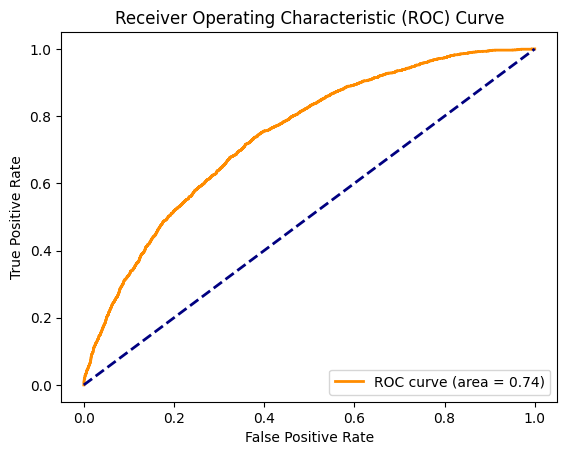

Epoch: 7 | Iter:    0 | Time: 00:00:45 | Train Loss: 1.2032 | Average Loss: 1.2403 
Epoch: 7 | Iter:   20 | Time: 00:00:46 | Train Loss: 1.1325 | Average Loss: 1.2379 
Epoch: 7 | Iter:   40 | Time: 00:00:47 | Train Loss: 1.1471 | Average Loss: 1.2365 
Epoch: 7 | Iter:   60 | Time: 00:00:48 | Train Loss: 1.1008 | Average Loss: 1.2348 
Epoch: 7 | Iter:   80 | Time: 00:00:49 | Train Loss: 1.1967 | Average Loss: 1.2327 
Epoch: 7 | Iter:  100 | Time: 00:00:50 | Train Loss: 1.1532 | Average Loss: 1.2305 
Epoch: 7 | Iter:  120 | Time: 00:00:51 | Train Loss: 1.1534 | Average Loss: 1.2290 
Accuracy: 0.4759


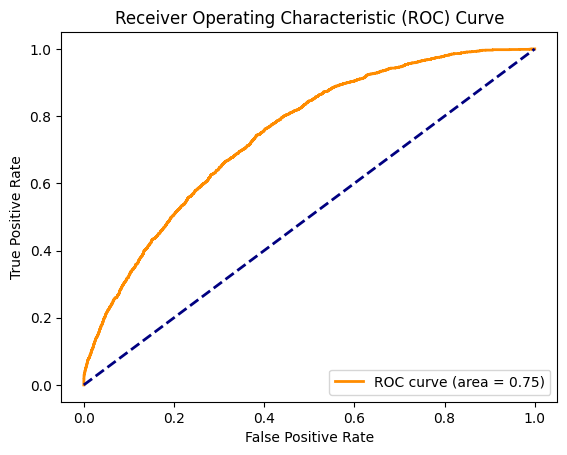

Epoch: 8 | Iter:    0 | Time: 00:00:52 | Train Loss: 1.1198 | Average Loss: 1.2275 
Epoch: 8 | Iter:   20 | Time: 00:00:53 | Train Loss: 1.1453 | Average Loss: 1.2255 
Epoch: 8 | Iter:   40 | Time: 00:00:54 | Train Loss: 1.1816 | Average Loss: 1.2241 
Epoch: 8 | Iter:   60 | Time: 00:00:55 | Train Loss: 1.0989 | Average Loss: 1.2227 
Epoch: 8 | Iter:   80 | Time: 00:00:56 | Train Loss: 1.0808 | Average Loss: 1.2208 
Epoch: 8 | Iter:  100 | Time: 00:00:57 | Train Loss: 1.0775 | Average Loss: 1.2188 
Epoch: 8 | Iter:  120 | Time: 00:00:58 | Train Loss: 1.2262 | Average Loss: 1.2168 
Accuracy: 0.5188


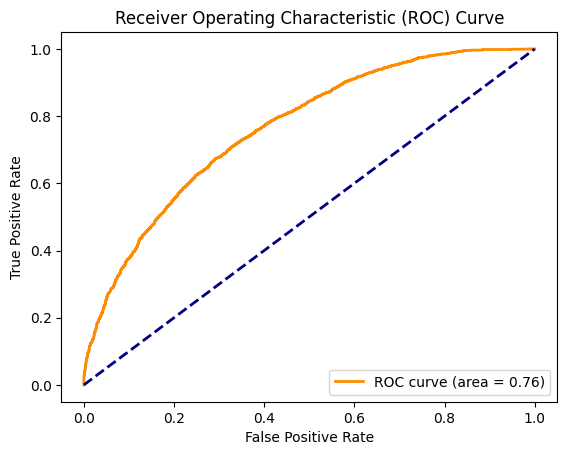

Epoch: 9 | Iter:    0 | Time: 00:00:59 | Train Loss: 1.1125 | Average Loss: 1.2151 
Epoch: 9 | Iter:   20 | Time: 00:01:00 | Train Loss: 1.0256 | Average Loss: 1.2126 
Epoch: 9 | Iter:   40 | Time: 00:01:01 | Train Loss: 1.1492 | Average Loss: 1.2110 
Epoch: 9 | Iter:   60 | Time: 00:01:02 | Train Loss: 1.1146 | Average Loss: 1.2093 
Epoch: 9 | Iter:   80 | Time: 00:01:03 | Train Loss: 1.0791 | Average Loss: 1.2075 
Epoch: 9 | Iter:  100 | Time: 00:01:04 | Train Loss: 1.2147 | Average Loss: 1.2057 
Epoch: 9 | Iter:  120 | Time: 00:01:05 | Train Loss: 1.0917 | Average Loss: 1.2037 
Accuracy: 0.5152


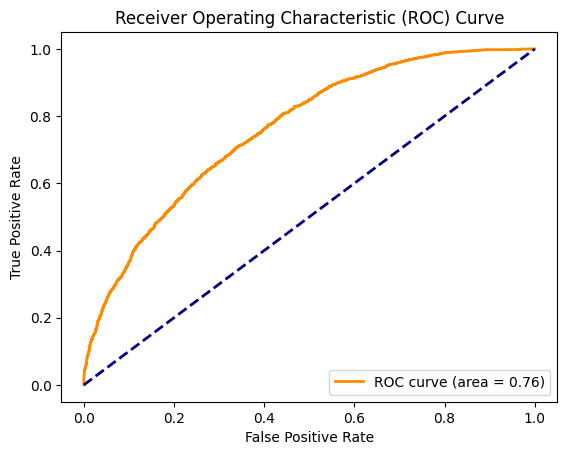

Epoch:10 | Iter:    0 | Time: 00:01:07 | Train Loss: 1.1891 | Average Loss: 1.2020 
Epoch:10 | Iter:   20 | Time: 00:01:08 | Train Loss: 1.0435 | Average Loss: 1.1996 
Epoch:10 | Iter:   40 | Time: 00:01:09 | Train Loss: 1.1528 | Average Loss: 1.1977 
Epoch:10 | Iter:   60 | Time: 00:01:10 | Train Loss: 1.0651 | Average Loss: 1.1959 
Epoch:10 | Iter:   80 | Time: 00:01:11 | Train Loss: 1.1276 | Average Loss: 1.1939 
Epoch:10 | Iter:  100 | Time: 00:01:12 | Train Loss: 1.1016 | Average Loss: 1.1920 
Epoch:10 | Iter:  120 | Time: 00:01:13 | Train Loss: 1.1418 | Average Loss: 1.1903 
Accuracy: 0.5379


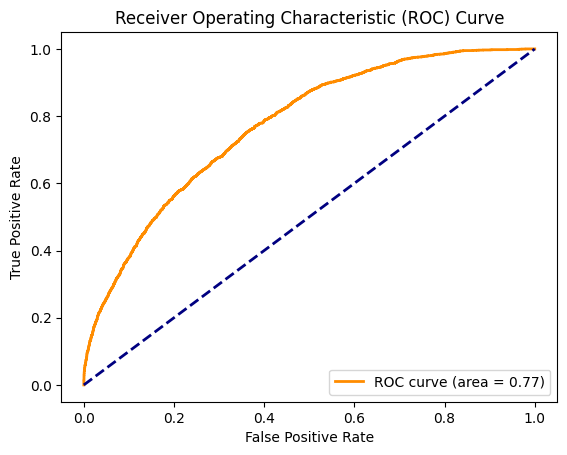

Epoch:11 | Iter:    0 | Time: 00:01:14 | Train Loss: 1.1293 | Average Loss: 1.1887 
Epoch:11 | Iter:   20 | Time: 00:01:15 | Train Loss: 1.0133 | Average Loss: 1.1866 
Epoch:11 | Iter:   40 | Time: 00:01:16 | Train Loss: 1.1290 | Average Loss: 1.1850 
Epoch:11 | Iter:   60 | Time: 00:01:17 | Train Loss: 1.0623 | Average Loss: 1.1833 
Epoch:11 | Iter:   80 | Time: 00:01:18 | Train Loss: 1.0067 | Average Loss: 1.1816 
Epoch:11 | Iter:  100 | Time: 00:01:19 | Train Loss: 1.0325 | Average Loss: 1.1796 
Epoch:11 | Iter:  120 | Time: 00:01:20 | Train Loss: 1.0916 | Average Loss: 1.1783 
Accuracy: 0.5580


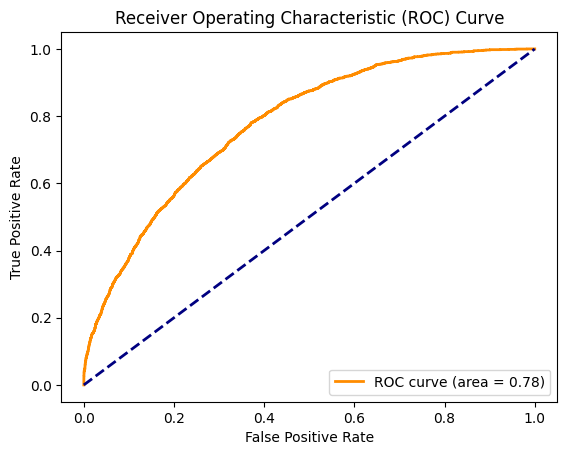

Epoch:12 | Iter:    0 | Time: 00:01:22 | Train Loss: 1.0576 | Average Loss: 1.1770 
Epoch:12 | Iter:   20 | Time: 00:01:23 | Train Loss: 1.0352 | Average Loss: 1.1748 
Epoch:12 | Iter:   40 | Time: 00:01:24 | Train Loss: 0.9951 | Average Loss: 1.1732 
Epoch:12 | Iter:   60 | Time: 00:01:25 | Train Loss: 1.0486 | Average Loss: 1.1716 
Epoch:12 | Iter:   80 | Time: 00:01:26 | Train Loss: 1.0924 | Average Loss: 1.1699 
Epoch:12 | Iter:  100 | Time: 00:01:27 | Train Loss: 1.0513 | Average Loss: 1.1681 
Epoch:12 | Iter:  120 | Time: 00:01:28 | Train Loss: 1.0765 | Average Loss: 1.1666 
Accuracy: 0.5629


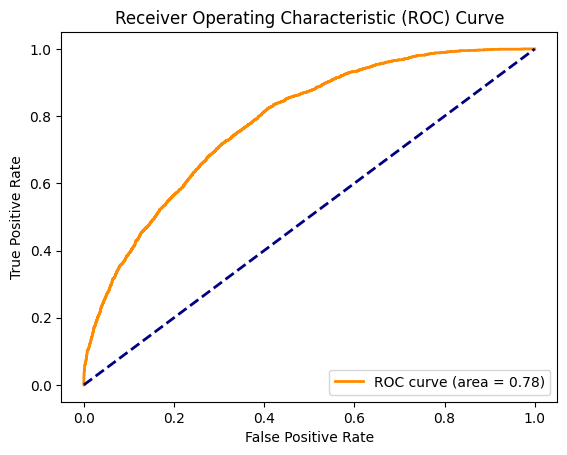

Epoch:13 | Iter:    0 | Time: 00:01:29 | Train Loss: 0.9773 | Average Loss: 1.1653 
Epoch:13 | Iter:   20 | Time: 00:01:30 | Train Loss: 0.9665 | Average Loss: 1.1634 
Epoch:13 | Iter:   40 | Time: 00:01:31 | Train Loss: 0.9668 | Average Loss: 1.1620 
Epoch:13 | Iter:   60 | Time: 00:01:32 | Train Loss: 1.0656 | Average Loss: 1.1604 
Epoch:13 | Iter:   80 | Time: 00:01:33 | Train Loss: 1.0251 | Average Loss: 1.1589 
Epoch:13 | Iter:  100 | Time: 00:01:34 | Train Loss: 1.0088 | Average Loss: 1.1570 
Epoch:13 | Iter:  120 | Time: 00:01:35 | Train Loss: 1.1121 | Average Loss: 1.1554 
Accuracy: 0.5585


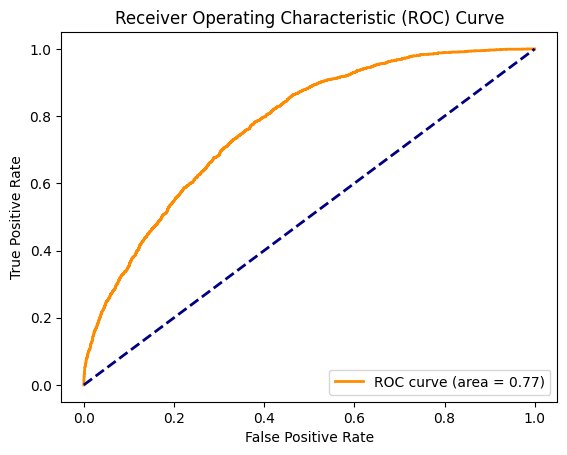

Epoch:14 | Iter:    0 | Time: 00:01:37 | Train Loss: 1.0682 | Average Loss: 1.1545 
Epoch:14 | Iter:   20 | Time: 00:01:38 | Train Loss: 0.9315 | Average Loss: 1.1525 
Epoch:14 | Iter:   40 | Time: 00:01:39 | Train Loss: 1.0433 | Average Loss: 1.1509 
Epoch:14 | Iter:   60 | Time: 00:01:40 | Train Loss: 0.8938 | Average Loss: 1.1493 
Epoch:14 | Iter:   80 | Time: 00:01:41 | Train Loss: 0.9271 | Average Loss: 1.1476 
Epoch:14 | Iter:  100 | Time: 00:01:42 | Train Loss: 1.0425 | Average Loss: 1.1457 
Epoch:14 | Iter:  120 | Time: 00:01:43 | Train Loss: 1.1018 | Average Loss: 1.1444 
Accuracy: 0.5647


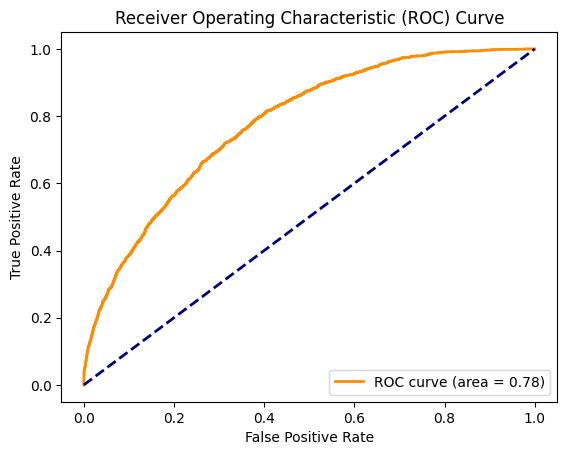

Epoch:15 | Iter:    0 | Time: 00:01:44 | Train Loss: 1.0402 | Average Loss: 1.1433 
Epoch:15 | Iter:   20 | Time: 00:01:45 | Train Loss: 0.8724 | Average Loss: 1.1415 
Epoch:15 | Iter:   40 | Time: 00:01:46 | Train Loss: 1.0865 | Average Loss: 1.1401 
Epoch:15 | Iter:   60 | Time: 00:01:47 | Train Loss: 0.8737 | Average Loss: 1.1387 
Epoch:15 | Iter:   80 | Time: 00:01:48 | Train Loss: 0.9400 | Average Loss: 1.1372 
Epoch:15 | Iter:  100 | Time: 00:01:49 | Train Loss: 0.8992 | Average Loss: 1.1356 
Accuracy: 0.5687


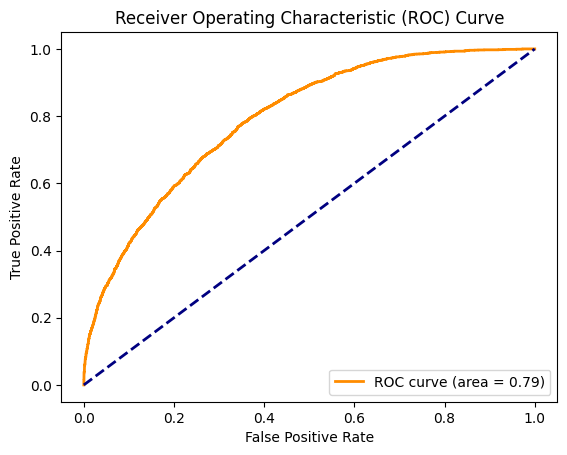

Epoch:16 | Iter:    0 | Time: 00:01:52 | Train Loss: 0.9771 | Average Loss: 1.1333 
Epoch:16 | Iter:   20 | Time: 00:01:53 | Train Loss: 0.9377 | Average Loss: 1.1314 
Epoch:16 | Iter:   40 | Time: 00:01:54 | Train Loss: 0.9987 | Average Loss: 1.1300 
Epoch:16 | Iter:   60 | Time: 00:01:55 | Train Loss: 0.8668 | Average Loss: 1.1284 
Epoch:16 | Iter:   80 | Time: 00:01:56 | Train Loss: 0.9168 | Average Loss: 1.1271 
Epoch:16 | Iter:  100 | Time: 00:01:57 | Train Loss: 0.9725 | Average Loss: 1.1256 
Epoch:16 | Iter:  120 | Time: 00:01:57 | Train Loss: 1.0551 | Average Loss: 1.1246 
Accuracy: 0.5750


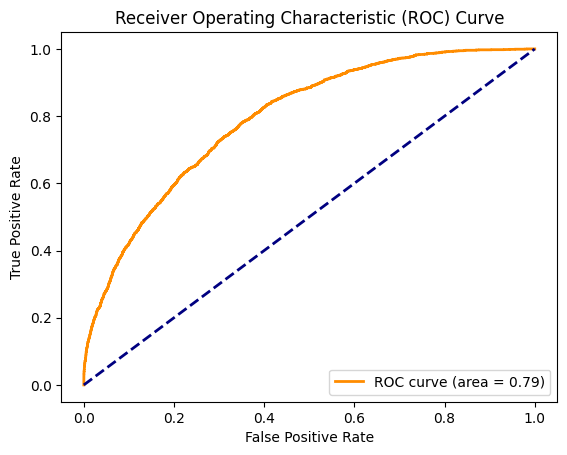

Epoch:17 | Iter:    0 | Time: 00:01:59 | Train Loss: 0.8371 | Average Loss: 1.1235 
Epoch:17 | Iter:   20 | Time: 00:02:00 | Train Loss: 1.0338 | Average Loss: 1.1219 
Epoch:17 | Iter:   40 | Time: 00:02:01 | Train Loss: 0.9301 | Average Loss: 1.1207 
Epoch:17 | Iter:   60 | Time: 00:02:02 | Train Loss: 0.8613 | Average Loss: 1.1192 
Epoch:17 | Iter:   80 | Time: 00:02:03 | Train Loss: 0.9503 | Average Loss: 1.1176 
Epoch:17 | Iter:  100 | Time: 00:02:04 | Train Loss: 0.9376 | Average Loss: 1.1162 
Epoch:17 | Iter:  120 | Time: 00:02:05 | Train Loss: 1.0147 | Average Loss: 1.1148 
Accuracy: 0.5786


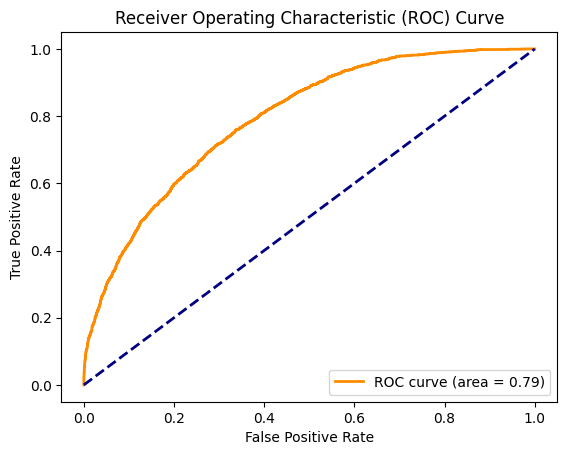

Epoch:18 | Iter:    0 | Time: 00:02:07 | Train Loss: 0.9136 | Average Loss: 1.1138 
Epoch:18 | Iter:   20 | Time: 00:02:07 | Train Loss: 0.9517 | Average Loss: 1.1122 
Epoch:18 | Iter:   40 | Time: 00:02:08 | Train Loss: 0.8350 | Average Loss: 1.1112 
Epoch:18 | Iter:   60 | Time: 00:02:09 | Train Loss: 0.9573 | Average Loss: 1.1098 
Epoch:18 | Iter:   80 | Time: 00:02:10 | Train Loss: 1.0153 | Average Loss: 1.1085 
Epoch:18 | Iter:  100 | Time: 00:02:11 | Train Loss: 0.8876 | Average Loss: 1.1071 
Epoch:18 | Iter:  120 | Time: 00:02:12 | Train Loss: 1.1472 | Average Loss: 1.1058 
Accuracy: 0.5844


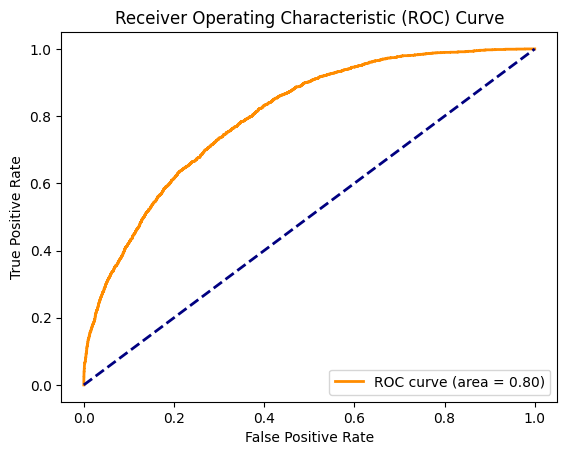

Epoch:19 | Iter:    0 | Time: 00:02:14 | Train Loss: 0.9067 | Average Loss: 1.1047 
Epoch:19 | Iter:   20 | Time: 00:02:15 | Train Loss: 0.8395 | Average Loss: 1.1032 
Epoch:19 | Iter:   40 | Time: 00:02:16 | Train Loss: 0.9920 | Average Loss: 1.1022 
Epoch:19 | Iter:   60 | Time: 00:02:17 | Train Loss: 0.8864 | Average Loss: 1.1009 
Epoch:19 | Iter:   80 | Time: 00:02:18 | Train Loss: 0.8647 | Average Loss: 1.0994 
Epoch:19 | Iter:  100 | Time: 00:02:19 | Train Loss: 0.9700 | Average Loss: 1.0980 
Epoch:19 | Iter:  120 | Time: 00:02:20 | Train Loss: 0.9883 | Average Loss: 1.0968 
Accuracy: 0.5768


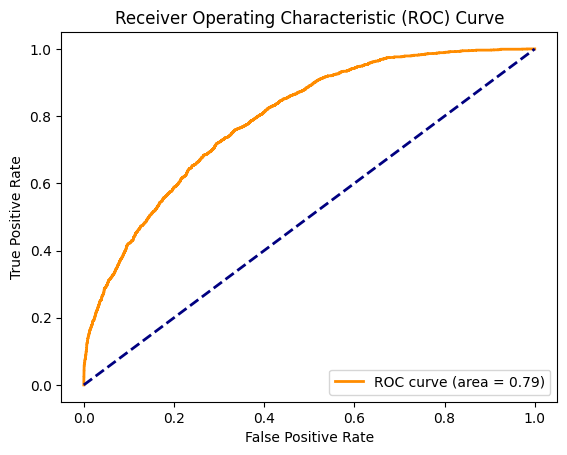

Epoch:20 | Iter:    0 | Time: 00:02:21 | Train Loss: 0.9620 | Average Loss: 1.0957 
Epoch:20 | Iter:   20 | Time: 00:02:22 | Train Loss: 0.8939 | Average Loss: 1.0940 
Epoch:20 | Iter:   40 | Time: 00:02:23 | Train Loss: 0.8825 | Average Loss: 1.0927 
Epoch:20 | Iter:   60 | Time: 00:02:24 | Train Loss: 0.8584 | Average Loss: 1.0916 
Epoch:20 | Iter:   80 | Time: 00:02:25 | Train Loss: 0.9181 | Average Loss: 1.0905 
Epoch:20 | Iter:  100 | Time: 00:02:26 | Train Loss: 0.9610 | Average Loss: 1.0889 
Epoch:20 | Iter:  120 | Time: 00:02:27 | Train Loss: 1.0414 | Average Loss: 1.0876 
Accuracy: 0.5982


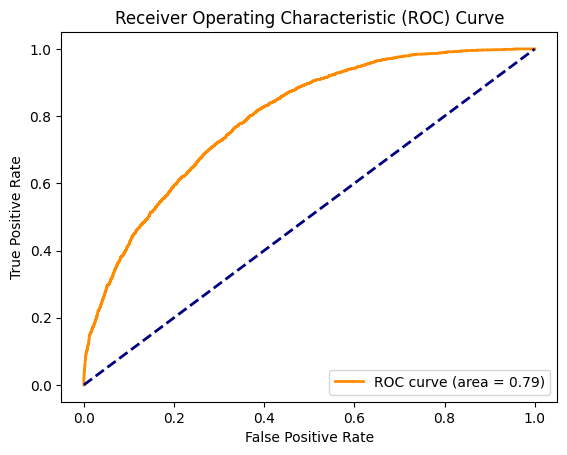

Epoch:21 | Iter:    0 | Time: 00:02:29 | Train Loss: 1.0106 | Average Loss: 1.0867 
Epoch:21 | Iter:   20 | Time: 00:02:30 | Train Loss: 0.8406 | Average Loss: 1.0852 
Epoch:21 | Iter:   40 | Time: 00:02:31 | Train Loss: 0.9918 | Average Loss: 1.0842 
Epoch:21 | Iter:   60 | Time: 00:02:32 | Train Loss: 0.8408 | Average Loss: 1.0829 
Epoch:21 | Iter:   80 | Time: 00:02:33 | Train Loss: 0.9945 | Average Loss: 1.0816 
Epoch:21 | Iter:  100 | Time: 00:02:34 | Train Loss: 0.8099 | Average Loss: 1.0803 
Epoch:21 | Iter:  120 | Time: 00:02:35 | Train Loss: 1.0272 | Average Loss: 1.0793 
Accuracy: 0.5893


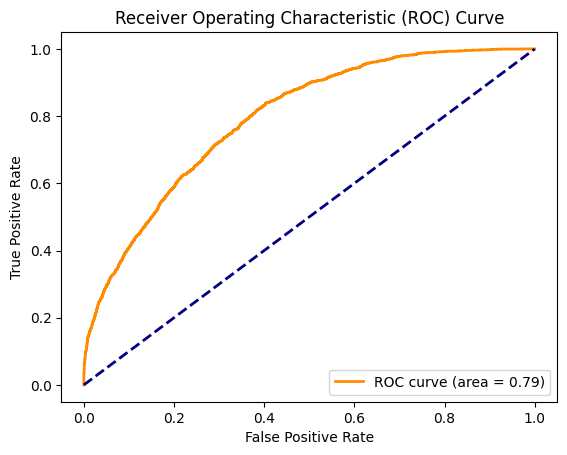

Epoch:22 | Iter:    0 | Time: 00:02:36 | Train Loss: 0.8938 | Average Loss: 1.0782 
Epoch:22 | Iter:   20 | Time: 00:02:37 | Train Loss: 0.8156 | Average Loss: 1.0770 
Epoch:22 | Iter:   40 | Time: 00:02:38 | Train Loss: 0.8870 | Average Loss: 1.0759 
Epoch:22 | Iter:   60 | Time: 00:02:39 | Train Loss: 0.7490 | Average Loss: 1.0748 
Epoch:22 | Iter:   80 | Time: 00:02:40 | Train Loss: 0.8885 | Average Loss: 1.0738 
Epoch:22 | Iter:  100 | Time: 00:02:41 | Train Loss: 0.7512 | Average Loss: 1.0724 
Epoch:22 | Iter:  120 | Time: 00:02:42 | Train Loss: 1.0182 | Average Loss: 1.0713 
Accuracy: 0.5906


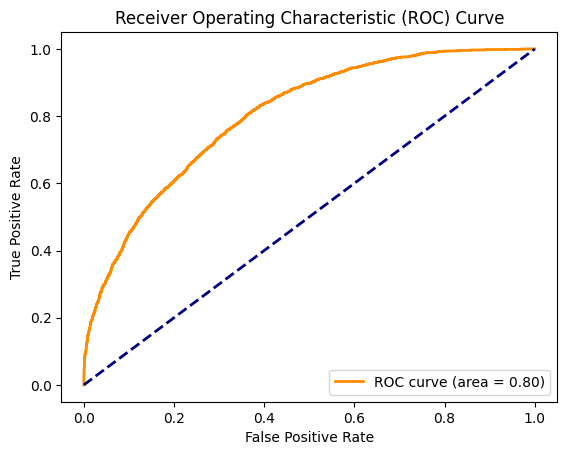

Epoch:23 | Iter:    0 | Time: 00:02:44 | Train Loss: 0.7625 | Average Loss: 1.0703 
Epoch:23 | Iter:   20 | Time: 00:02:45 | Train Loss: 0.7457 | Average Loss: 1.0691 
Epoch:23 | Iter:   40 | Time: 00:02:46 | Train Loss: 0.8210 | Average Loss: 1.0680 
Epoch:23 | Iter:   60 | Time: 00:02:47 | Train Loss: 0.7164 | Average Loss: 1.0668 
Epoch:23 | Iter:   80 | Time: 00:02:48 | Train Loss: 0.7478 | Average Loss: 1.0656 
Epoch:23 | Iter:  100 | Time: 00:02:49 | Train Loss: 0.9035 | Average Loss: 1.0642 
Epoch:23 | Iter:  120 | Time: 00:02:50 | Train Loss: 1.0989 | Average Loss: 1.0633 
Accuracy: 0.5848


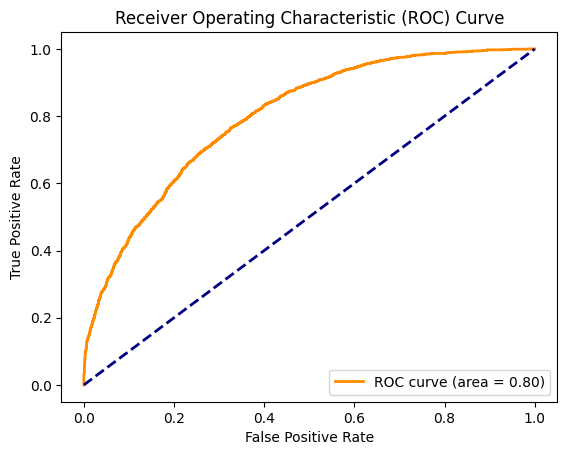

Epoch:24 | Iter:    0 | Time: 00:02:51 | Train Loss: 1.1040 | Average Loss: 1.0624 
Epoch:24 | Iter:   20 | Time: 00:02:52 | Train Loss: 0.8399 | Average Loss: 1.0611 
Epoch:24 | Iter:   40 | Time: 00:02:53 | Train Loss: 0.8600 | Average Loss: 1.0601 
Epoch:24 | Iter:   60 | Time: 00:02:54 | Train Loss: 0.8331 | Average Loss: 1.0589 
Epoch:24 | Iter:   80 | Time: 00:02:55 | Train Loss: 0.8351 | Average Loss: 1.0577 
Epoch:24 | Iter:  100 | Time: 00:02:56 | Train Loss: 0.8631 | Average Loss: 1.0564 
Epoch:24 | Iter:  120 | Time: 00:02:57 | Train Loss: 1.0308 | Average Loss: 1.0555 
Accuracy: 0.5875


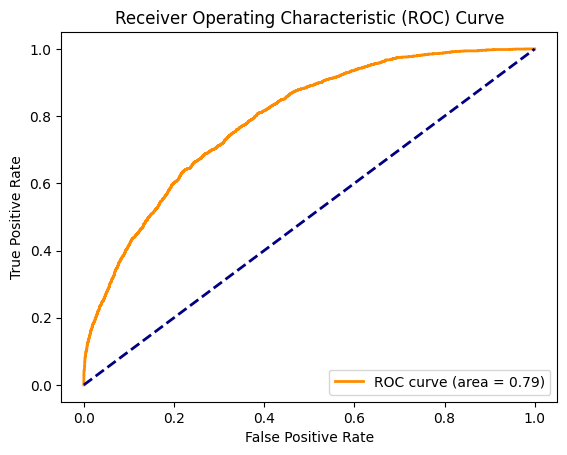

Epoch:25 | Iter:    0 | Time: 00:02:59 | Train Loss: 0.7783 | Average Loss: 1.0546 
Epoch:25 | Iter:   20 | Time: 00:03:00 | Train Loss: 0.7839 | Average Loss: 1.0534 
Epoch:25 | Iter:   40 | Time: 00:03:01 | Train Loss: 0.9781 | Average Loss: 1.0525 
Epoch:25 | Iter:   60 | Time: 00:03:02 | Train Loss: 0.8510 | Average Loss: 1.0515 
Epoch:25 | Iter:   80 | Time: 00:03:02 | Train Loss: 0.8252 | Average Loss: 1.0502 
Epoch:25 | Iter:  100 | Time: 00:03:03 | Train Loss: 0.7699 | Average Loss: 1.0492 
Epoch:25 | Iter:  120 | Time: 00:03:04 | Train Loss: 1.0207 | Average Loss: 1.0485 
Accuracy: 0.5857


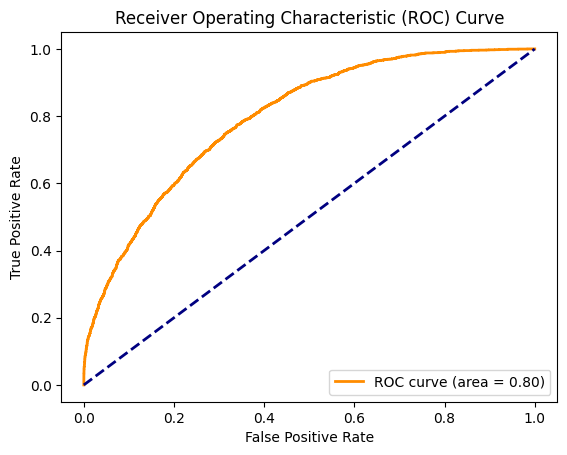

Epoch:26 | Iter:    0 | Time: 00:03:06 | Train Loss: 0.8368 | Average Loss: 1.0477 
Epoch:26 | Iter:   20 | Time: 00:03:07 | Train Loss: 0.8657 | Average Loss: 1.0464 
Epoch:26 | Iter:   40 | Time: 00:03:08 | Train Loss: 0.8140 | Average Loss: 1.0454 
Epoch:26 | Iter:   60 | Time: 00:03:09 | Train Loss: 0.7269 | Average Loss: 1.0443 
Epoch:26 | Iter:   80 | Time: 00:03:10 | Train Loss: 0.8025 | Average Loss: 1.0431 
Epoch:26 | Iter:  100 | Time: 00:03:11 | Train Loss: 0.8143 | Average Loss: 1.0418 
Epoch:26 | Iter:  120 | Time: 00:03:12 | Train Loss: 0.8792 | Average Loss: 1.0409 
Accuracy: 0.5853


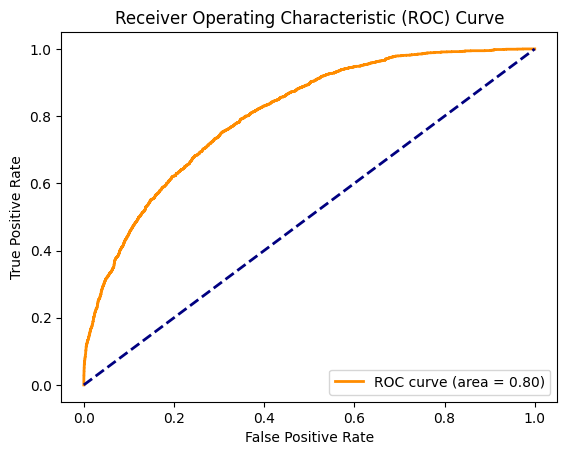

Epoch:27 | Iter:    0 | Time: 00:03:13 | Train Loss: 0.7866 | Average Loss: 1.0400 
Epoch:27 | Iter:   20 | Time: 00:03:14 | Train Loss: 0.7332 | Average Loss: 1.0388 
Epoch:27 | Iter:   40 | Time: 00:03:15 | Train Loss: 0.8319 | Average Loss: 1.0378 
Epoch:27 | Iter:   60 | Time: 00:03:16 | Train Loss: 0.8428 | Average Loss: 1.0368 
Epoch:27 | Iter:   80 | Time: 00:03:17 | Train Loss: 0.7759 | Average Loss: 1.0356 
Epoch:27 | Iter:  100 | Time: 00:03:18 | Train Loss: 0.6902 | Average Loss: 1.0344 
Epoch:27 | Iter:  120 | Time: 00:03:19 | Train Loss: 0.8985 | Average Loss: 1.0335 
Accuracy: 0.5786


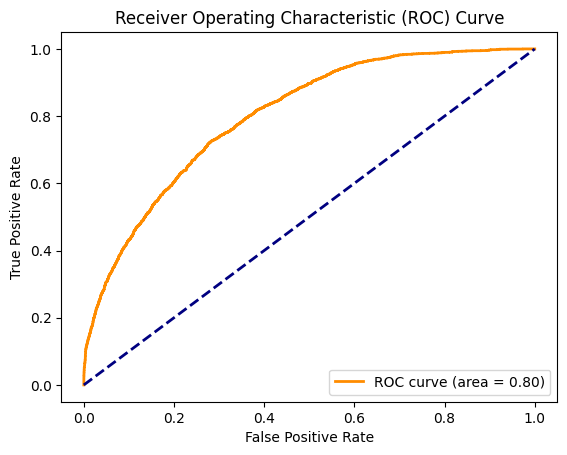

Epoch:28 | Iter:    0 | Time: 00:03:21 | Train Loss: 0.7527 | Average Loss: 1.0327 
Epoch:28 | Iter:   20 | Time: 00:03:22 | Train Loss: 0.8200 | Average Loss: 1.0315 
Epoch:28 | Iter:   40 | Time: 00:03:23 | Train Loss: 0.8392 | Average Loss: 1.0303 
Epoch:28 | Iter:   60 | Time: 00:03:24 | Train Loss: 0.7687 | Average Loss: 1.0293 
Epoch:28 | Iter:   80 | Time: 00:03:25 | Train Loss: 0.7910 | Average Loss: 1.0281 
Epoch:28 | Iter:  100 | Time: 00:03:26 | Train Loss: 0.7339 | Average Loss: 1.0271 
Epoch:28 | Iter:  120 | Time: 00:03:27 | Train Loss: 0.9539 | Average Loss: 1.0261 
Accuracy: 0.5768


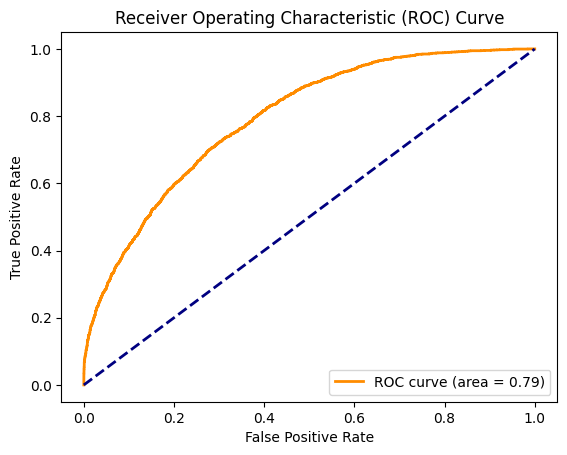

Epoch:29 | Iter:    0 | Time: 00:03:28 | Train Loss: 0.7425 | Average Loss: 1.0252 
Epoch:29 | Iter:   20 | Time: 00:03:29 | Train Loss: 0.6860 | Average Loss: 1.0242 
Epoch:29 | Iter:   40 | Time: 00:03:30 | Train Loss: 0.8499 | Average Loss: 1.0234 
Epoch:29 | Iter:   60 | Time: 00:03:31 | Train Loss: 0.7200 | Average Loss: 1.0223 
Epoch:29 | Iter:   80 | Time: 00:03:32 | Train Loss: 0.8093 | Average Loss: 1.0212 
Epoch:29 | Iter:  100 | Time: 00:03:33 | Train Loss: 0.6975 | Average Loss: 1.0201 
Epoch:29 | Iter:  120 | Time: 00:03:34 | Train Loss: 0.9052 | Average Loss: 1.0193 
Accuracy: 0.5839


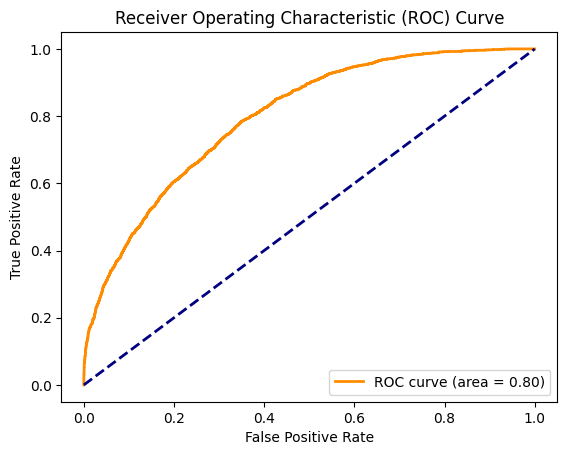

Epoch:30 | Iter:    0 | Time: 00:03:36 | Train Loss: 0.6623 | Average Loss: 1.0184 
Epoch:30 | Iter:   20 | Time: 00:03:37 | Train Loss: 0.8454 | Average Loss: 1.0174 
Epoch:30 | Iter:   40 | Time: 00:03:38 | Train Loss: 0.7995 | Average Loss: 1.0163 
Epoch:30 | Iter:   60 | Time: 00:03:39 | Train Loss: 0.6887 | Average Loss: 1.0155 
Epoch:30 | Iter:   80 | Time: 00:03:40 | Train Loss: 0.7504 | Average Loss: 1.0144 
Epoch:30 | Iter:  100 | Time: 00:03:41 | Train Loss: 0.7281 | Average Loss: 1.0133 
Epoch:30 | Iter:  120 | Time: 00:03:42 | Train Loss: 0.9660 | Average Loss: 1.0124 
Accuracy: 0.5862


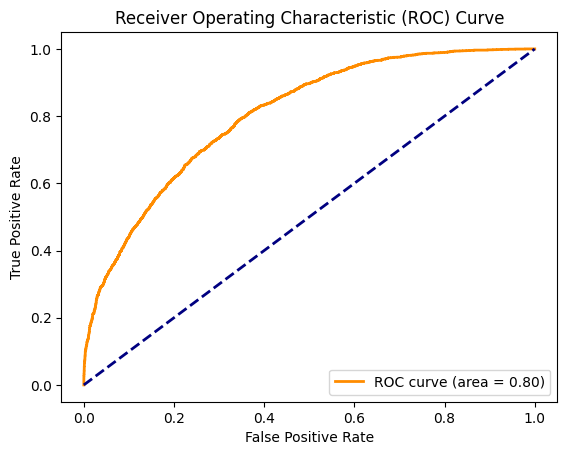

Epoch:31 | Iter:    0 | Time: 00:03:43 | Train Loss: 0.8701 | Average Loss: 1.0116 
Epoch:31 | Iter:   20 | Time: 00:03:44 | Train Loss: 0.8937 | Average Loss: 1.0106 
Epoch:31 | Iter:   40 | Time: 00:03:45 | Train Loss: 0.8437 | Average Loss: 1.0095 
Epoch:31 | Iter:   60 | Time: 00:03:46 | Train Loss: 0.5979 | Average Loss: 1.0084 
Epoch:31 | Iter:   80 | Time: 00:03:47 | Train Loss: 0.7719 | Average Loss: 1.0072 
Epoch:31 | Iter:  100 | Time: 00:03:48 | Train Loss: 0.6918 | Average Loss: 1.0062 
Epoch:31 | Iter:  120 | Time: 00:03:49 | Train Loss: 0.8735 | Average Loss: 1.0053 
Accuracy: 0.5884


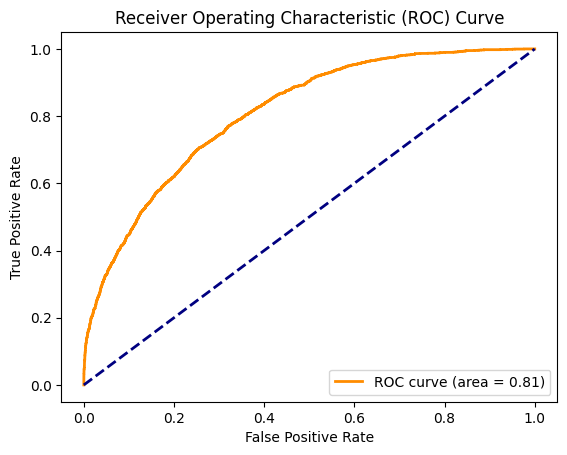

Epoch:32 | Iter:    0 | Time: 00:03:51 | Train Loss: 0.7865 | Average Loss: 1.0045 
Epoch:32 | Iter:   20 | Time: 00:03:52 | Train Loss: 0.7805 | Average Loss: 1.0035 
Epoch:32 | Iter:   40 | Time: 00:03:53 | Train Loss: 0.7363 | Average Loss: 1.0024 
Epoch:32 | Iter:   60 | Time: 00:03:54 | Train Loss: 0.6139 | Average Loss: 1.0014 
Epoch:32 | Iter:   80 | Time: 00:03:55 | Train Loss: 0.7479 | Average Loss: 1.0002 
Epoch:32 | Iter:  100 | Time: 00:03:56 | Train Loss: 0.7343 | Average Loss: 0.9992 
Epoch:32 | Iter:  120 | Time: 00:03:57 | Train Loss: 0.8965 | Average Loss: 0.9983 
Accuracy: 0.5938


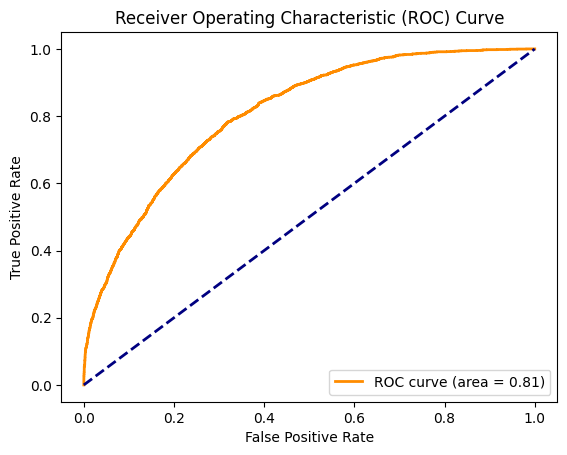

Epoch:33 | Iter:    0 | Time: 00:03:58 | Train Loss: 0.7715 | Average Loss: 0.9974 
Epoch:33 | Iter:   20 | Time: 00:03:59 | Train Loss: 0.7957 | Average Loss: 0.9965 
Epoch:33 | Iter:   40 | Time: 00:04:00 | Train Loss: 0.6128 | Average Loss: 0.9955 
Epoch:33 | Iter:   60 | Time: 00:04:01 | Train Loss: 0.6476 | Average Loss: 0.9945 
Epoch:33 | Iter:   80 | Time: 00:04:02 | Train Loss: 0.7818 | Average Loss: 0.9935 
Epoch:33 | Iter:  100 | Time: 00:04:03 | Train Loss: 0.7322 | Average Loss: 0.9923 
Epoch:33 | Iter:  120 | Time: 00:04:04 | Train Loss: 0.8766 | Average Loss: 0.9914 
Accuracy: 0.5879


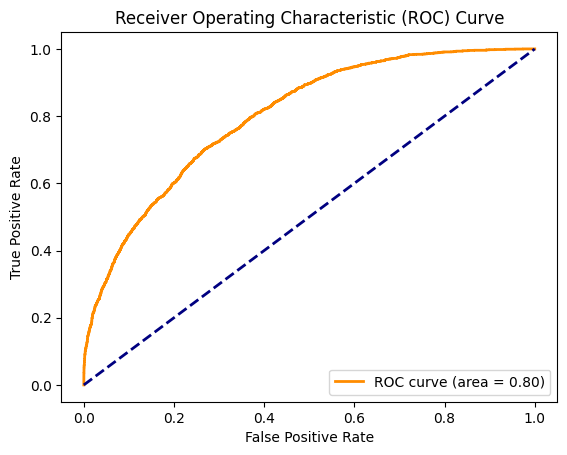

Epoch:34 | Iter:    0 | Time: 00:04:06 | Train Loss: 0.7122 | Average Loss: 0.9907 
Epoch:34 | Iter:   20 | Time: 00:04:07 | Train Loss: 0.7458 | Average Loss: 0.9896 
Epoch:34 | Iter:   40 | Time: 00:04:08 | Train Loss: 0.7104 | Average Loss: 0.9886 
Epoch:34 | Iter:   60 | Time: 00:04:09 | Train Loss: 0.6681 | Average Loss: 0.9875 
Epoch:34 | Iter:   80 | Time: 00:04:10 | Train Loss: 0.7998 | Average Loss: 0.9866 
Epoch:34 | Iter:  100 | Time: 00:04:10 | Train Loss: 0.6673 | Average Loss: 0.9855 
Epoch:34 | Iter:  120 | Time: 00:04:11 | Train Loss: 0.8310 | Average Loss: 0.9846 
Accuracy: 0.5920


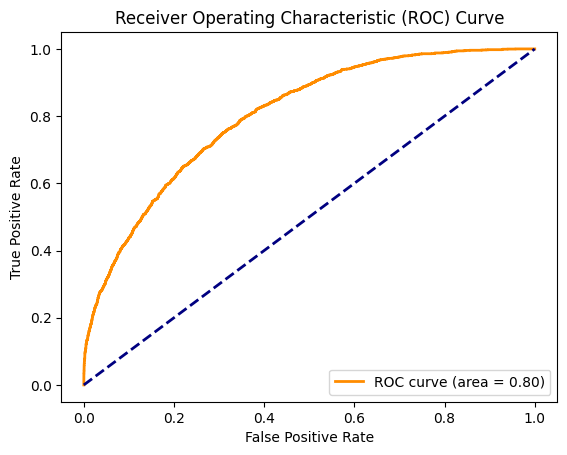

Epoch:35 | Iter:    0 | Time: 00:04:13 | Train Loss: 0.7574 | Average Loss: 0.9838 
Epoch:35 | Iter:   20 | Time: 00:04:14 | Train Loss: 0.6340 | Average Loss: 0.9829 
Epoch:35 | Iter:   40 | Time: 00:04:15 | Train Loss: 0.7916 | Average Loss: 0.9822 
Epoch:35 | Iter:   60 | Time: 00:04:16 | Train Loss: 0.6349 | Average Loss: 0.9812 
Epoch:35 | Iter:   80 | Time: 00:04:17 | Train Loss: 0.6843 | Average Loss: 0.9803 
Epoch:35 | Iter:  100 | Time: 00:04:18 | Train Loss: 0.6934 | Average Loss: 0.9792 
Epoch:35 | Iter:  120 | Time: 00:04:19 | Train Loss: 0.9483 | Average Loss: 0.9783 
Accuracy: 0.5920


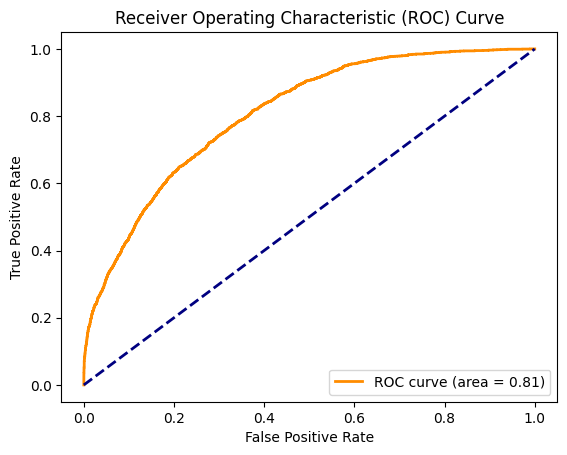

Epoch:36 | Iter:    0 | Time: 00:04:21 | Train Loss: 0.4881 | Average Loss: 0.9775 
Epoch:36 | Iter:   20 | Time: 00:04:22 | Train Loss: 0.6934 | Average Loss: 0.9765 
Epoch:36 | Iter:   40 | Time: 00:04:23 | Train Loss: 0.5677 | Average Loss: 0.9754 
Epoch:36 | Iter:   60 | Time: 00:04:24 | Train Loss: 0.6979 | Average Loss: 0.9745 
Epoch:36 | Iter:   80 | Time: 00:04:25 | Train Loss: 0.7004 | Average Loss: 0.9736 
Epoch:36 | Iter:  100 | Time: 00:04:26 | Train Loss: 0.6247 | Average Loss: 0.9725 
Epoch:36 | Iter:  120 | Time: 00:04:27 | Train Loss: 0.7561 | Average Loss: 0.9716 
Accuracy: 0.5982


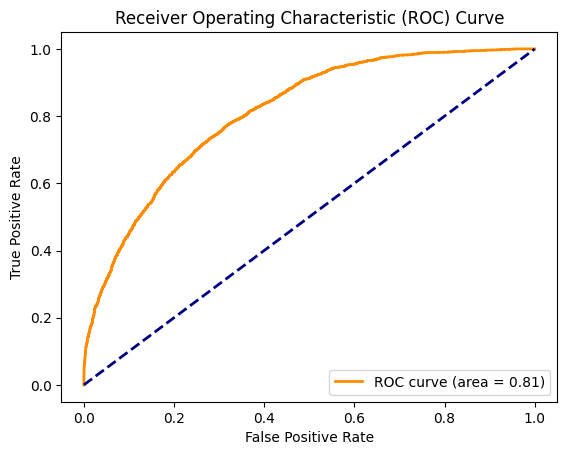

Epoch:37 | Iter:    0 | Time: 00:04:28 | Train Loss: 0.8003 | Average Loss: 0.9709 
Epoch:37 | Iter:   20 | Time: 00:04:29 | Train Loss: 0.7055 | Average Loss: 0.9698 
Epoch:37 | Iter:   40 | Time: 00:04:30 | Train Loss: 0.5758 | Average Loss: 0.9688 
Epoch:37 | Iter:   60 | Time: 00:04:31 | Train Loss: 0.4554 | Average Loss: 0.9678 
Epoch:37 | Iter:   80 | Time: 00:04:32 | Train Loss: 0.7795 | Average Loss: 0.9669 
Epoch:37 | Iter:  100 | Time: 00:04:33 | Train Loss: 0.6933 | Average Loss: 0.9660 
Epoch:37 | Iter:  120 | Time: 00:04:34 | Train Loss: 1.0203 | Average Loss: 0.9652 
Accuracy: 0.5830


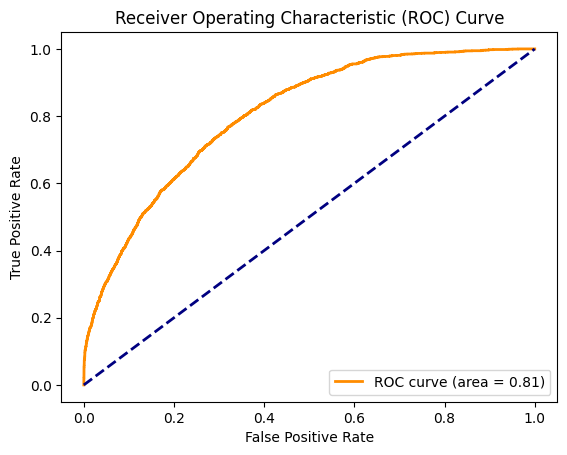

Epoch:38 | Iter:    0 | Time: 00:04:36 | Train Loss: 0.5509 | Average Loss: 0.9643 
Epoch:38 | Iter:   20 | Time: 00:04:37 | Train Loss: 0.7655 | Average Loss: 0.9635 
Epoch:38 | Iter:   40 | Time: 00:04:38 | Train Loss: 0.6214 | Average Loss: 0.9625 
Epoch:38 | Iter:   60 | Time: 00:04:39 | Train Loss: 0.7249 | Average Loss: 0.9616 
Epoch:38 | Iter:   80 | Time: 00:04:40 | Train Loss: 0.5659 | Average Loss: 0.9606 
Epoch:38 | Iter:  100 | Time: 00:04:41 | Train Loss: 0.7393 | Average Loss: 0.9596 
Epoch:38 | Iter:  120 | Time: 00:04:42 | Train Loss: 0.8809 | Average Loss: 0.9587 
Accuracy: 0.5875


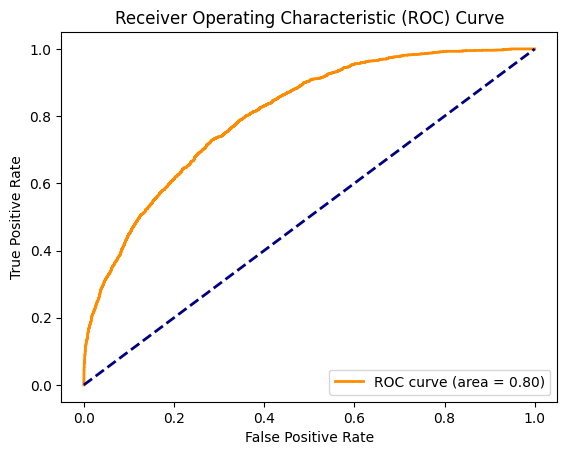

Epoch:39 | Iter:    0 | Time: 00:04:43 | Train Loss: 0.6958 | Average Loss: 0.9579 
Epoch:39 | Iter:   20 | Time: 00:04:44 | Train Loss: 0.6944 | Average Loss: 0.9569 
Epoch:39 | Iter:   40 | Time: 00:04:45 | Train Loss: 0.5773 | Average Loss: 0.9559 
Epoch:39 | Iter:   60 | Time: 00:04:46 | Train Loss: 0.5541 | Average Loss: 0.9548 
Epoch:39 | Iter:   80 | Time: 00:04:47 | Train Loss: 0.9352 | Average Loss: 0.9540 
Epoch:39 | Iter:  100 | Time: 00:04:48 | Train Loss: 0.7213 | Average Loss: 0.9531 
Epoch:39 | Iter:  120 | Time: 00:04:49 | Train Loss: 0.7686 | Average Loss: 0.9524 
Accuracy: 0.6054


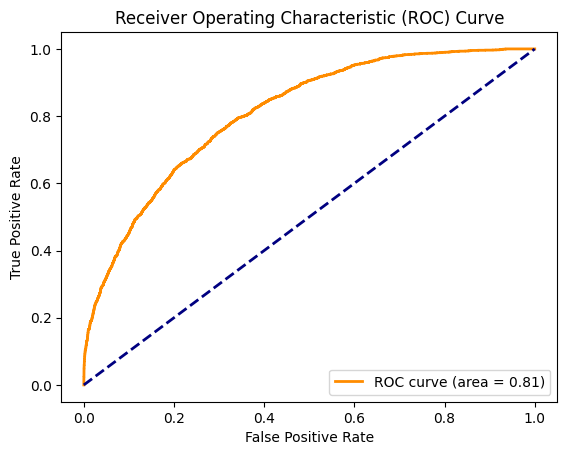

Epoch:40 | Iter:    0 | Time: 00:04:51 | Train Loss: 0.5699 | Average Loss: 0.9516 
Epoch:40 | Iter:   20 | Time: 00:04:52 | Train Loss: 0.8204 | Average Loss: 0.9508 
Epoch:40 | Iter:   40 | Time: 00:04:53 | Train Loss: 0.6469 | Average Loss: 0.9499 
Epoch:40 | Iter:   60 | Time: 00:04:54 | Train Loss: 0.5496 | Average Loss: 0.9489 
Epoch:40 | Iter:   80 | Time: 00:04:55 | Train Loss: 0.6865 | Average Loss: 0.9481 
Epoch:40 | Iter:  100 | Time: 00:04:56 | Train Loss: 0.6378 | Average Loss: 0.9472 
Epoch:40 | Iter:  120 | Time: 00:04:57 | Train Loss: 0.8094 | Average Loss: 0.9462 
Accuracy: 0.5973


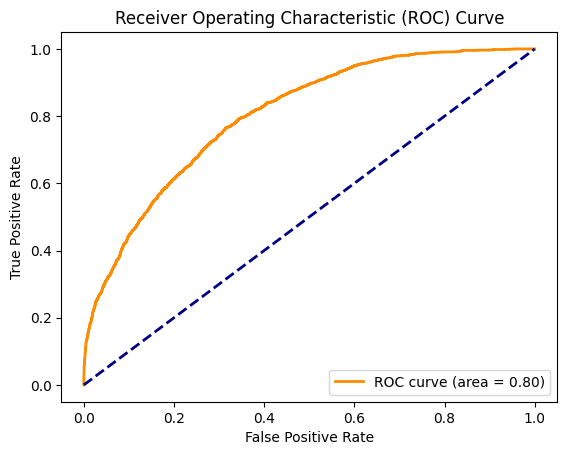

Epoch:41 | Iter:    0 | Time: 00:04:58 | Train Loss: 0.6104 | Average Loss: 0.9454 
Epoch:41 | Iter:   20 | Time: 00:04:59 | Train Loss: 0.6150 | Average Loss: 0.9444 
Epoch:41 | Iter:   40 | Time: 00:05:00 | Train Loss: 0.6675 | Average Loss: 0.9437 
Epoch:41 | Iter:   60 | Time: 00:05:01 | Train Loss: 0.6522 | Average Loss: 0.9428 
Epoch:41 | Iter:   80 | Time: 00:05:02 | Train Loss: 0.6497 | Average Loss: 0.9419 
Epoch:41 | Iter:  100 | Time: 00:05:03 | Train Loss: 0.5551 | Average Loss: 0.9411 
Epoch:41 | Iter:  120 | Time: 00:05:04 | Train Loss: 0.9733 | Average Loss: 0.9402 
Accuracy: 0.5817


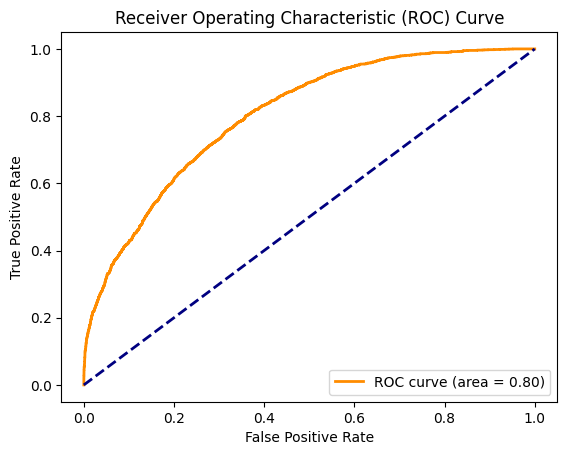

Epoch:42 | Iter:    0 | Time: 00:05:06 | Train Loss: 0.6804 | Average Loss: 0.9396 
Epoch:42 | Iter:   20 | Time: 00:05:07 | Train Loss: 0.5929 | Average Loss: 0.9387 
Epoch:42 | Iter:   40 | Time: 00:05:08 | Train Loss: 0.5638 | Average Loss: 0.9379 
Epoch:42 | Iter:   60 | Time: 00:05:09 | Train Loss: 0.6168 | Average Loss: 0.9370 
Epoch:42 | Iter:   80 | Time: 00:05:10 | Train Loss: 0.6388 | Average Loss: 0.9362 
Epoch:42 | Iter:  100 | Time: 00:05:11 | Train Loss: 0.5499 | Average Loss: 0.9353 
Epoch:42 | Iter:  120 | Time: 00:05:12 | Train Loss: 0.8375 | Average Loss: 0.9344 
Accuracy: 0.5906


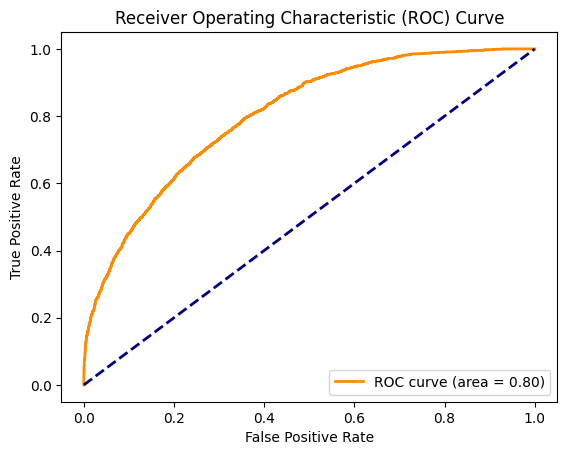

Epoch:43 | Iter:    0 | Time: 00:05:13 | Train Loss: 0.5781 | Average Loss: 0.9337 
Epoch:43 | Iter:   20 | Time: 00:05:14 | Train Loss: 0.7667 | Average Loss: 0.9330 
Epoch:43 | Iter:   40 | Time: 00:05:15 | Train Loss: 0.6554 | Average Loss: 0.9321 
Epoch:43 | Iter:   60 | Time: 00:05:16 | Train Loss: 0.6362 | Average Loss: 0.9312 
Epoch:43 | Iter:   80 | Time: 00:05:17 | Train Loss: 0.7778 | Average Loss: 0.9302 
Epoch:43 | Iter:  100 | Time: 00:05:18 | Train Loss: 0.5208 | Average Loss: 0.9293 
Epoch:43 | Iter:  120 | Time: 00:05:19 | Train Loss: 0.7028 | Average Loss: 0.9283 
Accuracy: 0.5884


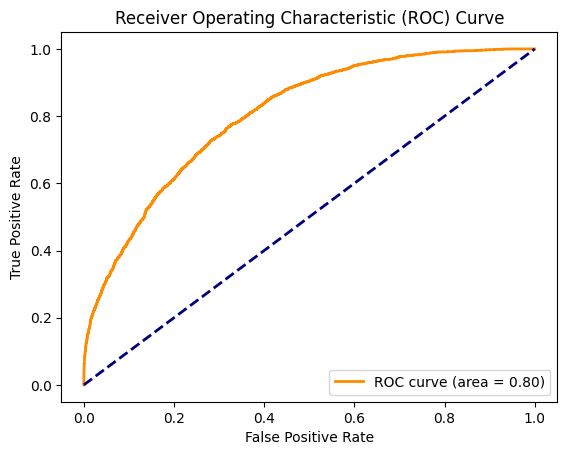

Epoch:44 | Iter:    0 | Time: 00:05:21 | Train Loss: 0.6938 | Average Loss: 0.9277 
Epoch:44 | Iter:   20 | Time: 00:05:22 | Train Loss: 0.6412 | Average Loss: 0.9267 
Epoch:44 | Iter:   40 | Time: 00:05:22 | Train Loss: 0.7242 | Average Loss: 0.9258 
Epoch:44 | Iter:   60 | Time: 00:05:23 | Train Loss: 0.5023 | Average Loss: 0.9250 
Epoch:44 | Iter:   80 | Time: 00:05:24 | Train Loss: 0.6937 | Average Loss: 0.9241 
Epoch:44 | Iter:  100 | Time: 00:05:25 | Train Loss: 0.5928 | Average Loss: 0.9231 
Epoch:44 | Iter:  120 | Time: 00:05:26 | Train Loss: 0.8483 | Average Loss: 0.9223 
Accuracy: 0.5884


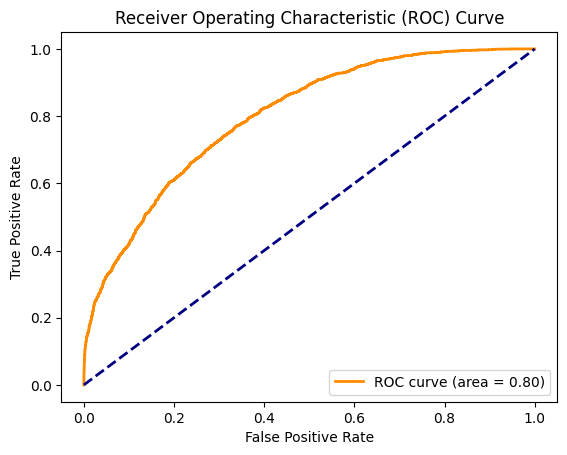

Epoch:45 | Iter:    0 | Time: 00:05:28 | Train Loss: 0.5778 | Average Loss: 0.9217 
Epoch:45 | Iter:   20 | Time: 00:05:29 | Train Loss: 0.6283 | Average Loss: 0.9207 
Epoch:45 | Iter:   40 | Time: 00:05:30 | Train Loss: 0.5390 | Average Loss: 0.9199 
Epoch:45 | Iter:   60 | Time: 00:05:31 | Train Loss: 0.7005 | Average Loss: 0.9191 
Epoch:45 | Iter:   80 | Time: 00:05:32 | Train Loss: 0.5878 | Average Loss: 0.9181 
Epoch:45 | Iter:  100 | Time: 00:05:33 | Train Loss: 0.5822 | Average Loss: 0.9173 
Epoch:45 | Iter:  120 | Time: 00:05:34 | Train Loss: 0.6960 | Average Loss: 0.9165 
Accuracy: 0.5777


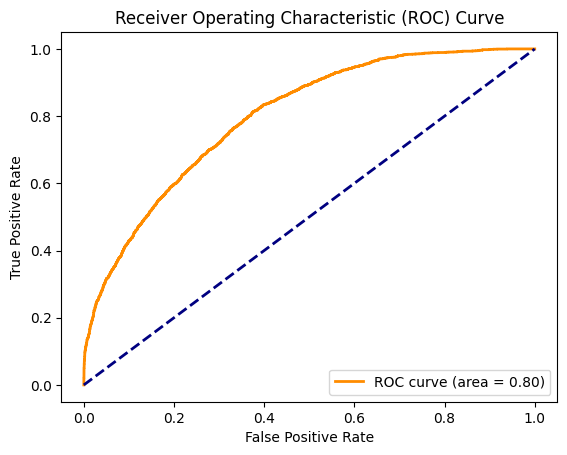

Epoch:46 | Iter:    0 | Time: 00:05:36 | Train Loss: 0.5157 | Average Loss: 0.9157 
Epoch:46 | Iter:   20 | Time: 00:05:36 | Train Loss: 0.9010 | Average Loss: 0.9149 
Epoch:46 | Iter:   40 | Time: 00:05:37 | Train Loss: 0.6872 | Average Loss: 0.9142 
Epoch:46 | Iter:   60 | Time: 00:05:38 | Train Loss: 0.6062 | Average Loss: 0.9133 
Epoch:46 | Iter:   80 | Time: 00:05:39 | Train Loss: 0.7084 | Average Loss: 0.9124 
Epoch:46 | Iter:  100 | Time: 00:05:40 | Train Loss: 0.5900 | Average Loss: 0.9115 
Epoch:46 | Iter:  120 | Time: 00:05:41 | Train Loss: 0.6977 | Average Loss: 0.9107 
Accuracy: 0.5763


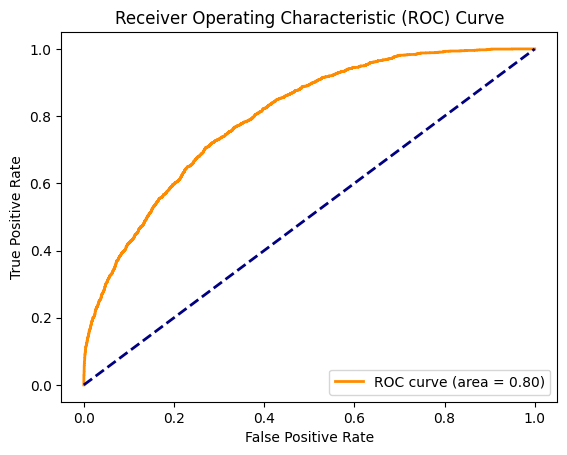

Epoch:47 | Iter:    0 | Time: 00:05:43 | Train Loss: 0.5464 | Average Loss: 0.9100 
Epoch:47 | Iter:   20 | Time: 00:05:44 | Train Loss: 0.5105 | Average Loss: 0.9092 
Epoch:47 | Iter:   40 | Time: 00:05:45 | Train Loss: 0.6225 | Average Loss: 0.9083 
Epoch:47 | Iter:   60 | Time: 00:05:46 | Train Loss: 0.5121 | Average Loss: 0.9073 
Epoch:47 | Iter:   80 | Time: 00:05:47 | Train Loss: 0.7920 | Average Loss: 0.9065 
Epoch:47 | Iter:  100 | Time: 00:05:48 | Train Loss: 0.5994 | Average Loss: 0.9056 
Epoch:47 | Iter:  120 | Time: 00:05:49 | Train Loss: 0.5482 | Average Loss: 0.9049 
Accuracy: 0.5871


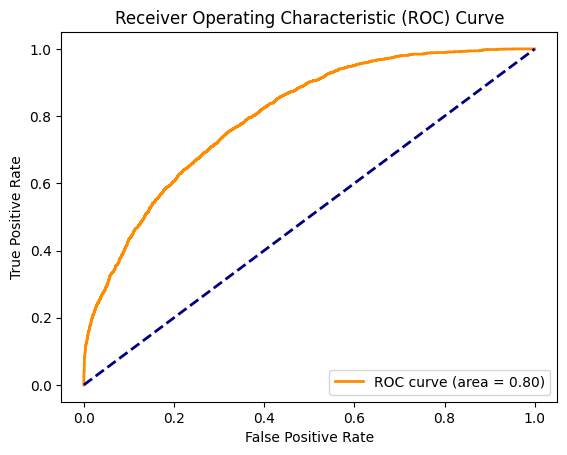

Epoch:48 | Iter:    0 | Time: 00:05:50 | Train Loss: 0.4332 | Average Loss: 0.9042 
Epoch:48 | Iter:   20 | Time: 00:05:51 | Train Loss: 0.5445 | Average Loss: 0.9033 
Epoch:48 | Iter:   40 | Time: 00:05:52 | Train Loss: 0.6295 | Average Loss: 0.9026 
Epoch:48 | Iter:   60 | Time: 00:05:53 | Train Loss: 0.5293 | Average Loss: 0.9017 
Epoch:48 | Iter:   80 | Time: 00:05:54 | Train Loss: 0.4515 | Average Loss: 0.9007 
Epoch:48 | Iter:  100 | Time: 00:05:55 | Train Loss: 0.4738 | Average Loss: 0.8998 
Epoch:48 | Iter:  120 | Time: 00:05:56 | Train Loss: 0.8862 | Average Loss: 0.8991 
Accuracy: 0.5946


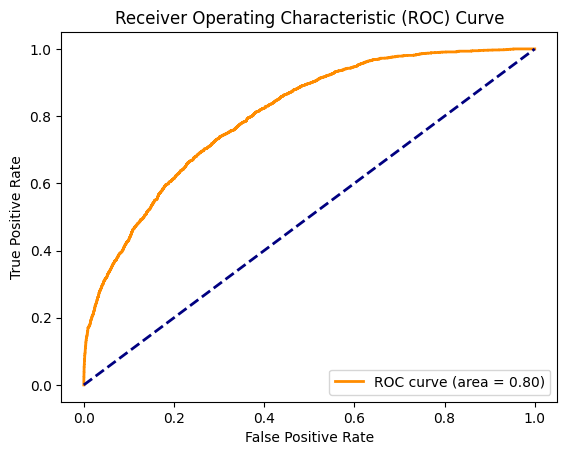

Epoch:49 | Iter:    0 | Time: 00:05:58 | Train Loss: 0.5015 | Average Loss: 0.8983 
Epoch:49 | Iter:   20 | Time: 00:05:59 | Train Loss: 0.5623 | Average Loss: 0.8975 
Epoch:49 | Iter:   40 | Time: 00:06:00 | Train Loss: 0.5110 | Average Loss: 0.8967 
Epoch:49 | Iter:   60 | Time: 00:06:01 | Train Loss: 0.5867 | Average Loss: 0.8958 
Epoch:49 | Iter:   80 | Time: 00:06:02 | Train Loss: 0.3905 | Average Loss: 0.8949 
Epoch:49 | Iter:  100 | Time: 00:06:03 | Train Loss: 0.5302 | Average Loss: 0.8940 
Epoch:49 | Iter:  120 | Time: 00:06:04 | Train Loss: 0.7270 | Average Loss: 0.8932 
Accuracy: 0.6018


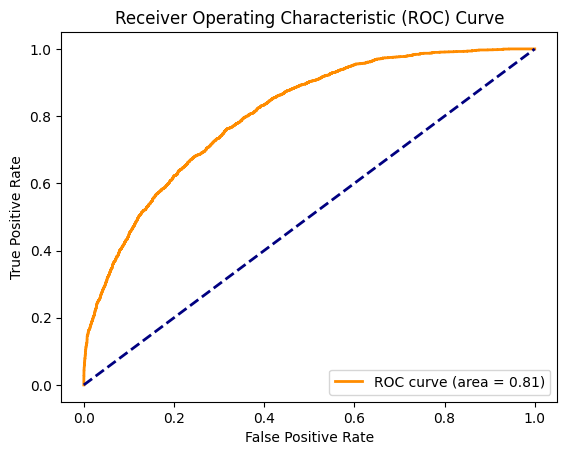

Epoch:50 | Iter:    0 | Time: 00:06:06 | Train Loss: 0.4985 | Average Loss: 0.8925 
Epoch:50 | Iter:   20 | Time: 00:06:06 | Train Loss: 0.4483 | Average Loss: 0.8915 
Epoch:50 | Iter:   40 | Time: 00:06:07 | Train Loss: 0.4793 | Average Loss: 0.8908 
Epoch:50 | Iter:   60 | Time: 00:06:08 | Train Loss: 0.4802 | Average Loss: 0.8899 
Epoch:50 | Iter:   80 | Time: 00:06:09 | Train Loss: 0.6146 | Average Loss: 0.8891 
Epoch:50 | Iter:  100 | Time: 00:06:10 | Train Loss: 0.4648 | Average Loss: 0.8882 
Epoch:50 | Iter:  120 | Time: 00:06:11 | Train Loss: 0.7508 | Average Loss: 0.8873 
Accuracy: 0.5888


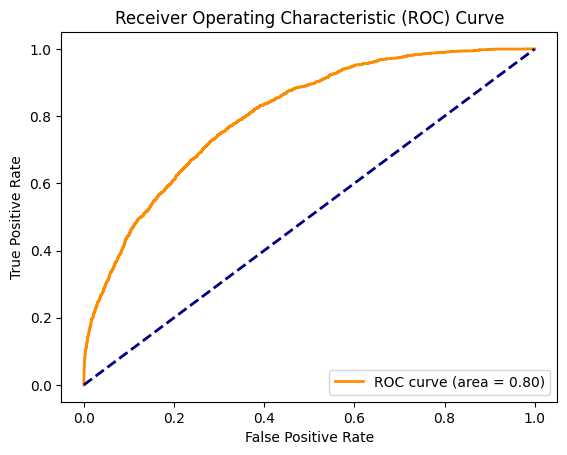

Epoch:51 | Iter:    0 | Time: 00:06:13 | Train Loss: 0.5475 | Average Loss: 0.8866 
Epoch:51 | Iter:   20 | Time: 00:06:14 | Train Loss: 0.4564 | Average Loss: 0.8858 
Epoch:51 | Iter:   40 | Time: 00:06:15 | Train Loss: 0.4662 | Average Loss: 0.8849 
Epoch:51 | Iter:   60 | Time: 00:06:16 | Train Loss: 0.5135 | Average Loss: 0.8840 
Epoch:51 | Iter:   80 | Time: 00:06:17 | Train Loss: 0.6026 | Average Loss: 0.8831 
Epoch:51 | Iter:  100 | Time: 00:06:18 | Train Loss: 0.6138 | Average Loss: 0.8823 
Epoch:51 | Iter:  120 | Time: 00:06:19 | Train Loss: 0.7118 | Average Loss: 0.8814 
Accuracy: 0.5915


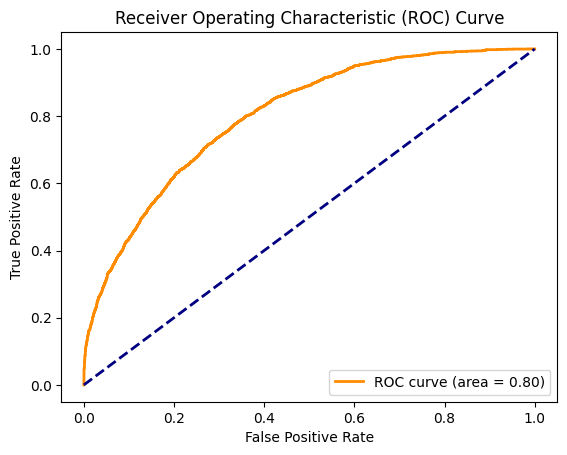

Epoch:52 | Iter:    0 | Time: 00:06:20 | Train Loss: 0.6997 | Average Loss: 0.8808 
Epoch:52 | Iter:   20 | Time: 00:06:21 | Train Loss: 0.6183 | Average Loss: 0.8799 
Epoch:52 | Iter:   40 | Time: 00:06:22 | Train Loss: 0.4257 | Average Loss: 0.8790 
Epoch:52 | Iter:   60 | Time: 00:06:23 | Train Loss: 0.4128 | Average Loss: 0.8782 
Epoch:52 | Iter:   80 | Time: 00:06:24 | Train Loss: 0.6106 | Average Loss: 0.8772 
Epoch:52 | Iter:  100 | Time: 00:06:25 | Train Loss: 0.4012 | Average Loss: 0.8764 
Epoch:52 | Iter:  120 | Time: 00:06:26 | Train Loss: 0.7301 | Average Loss: 0.8757 
Accuracy: 0.5973


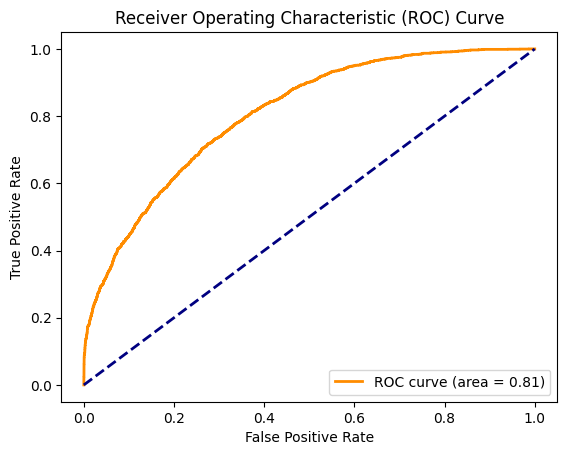

Epoch:53 | Iter:    0 | Time: 00:06:28 | Train Loss: 0.5347 | Average Loss: 0.8750 
Epoch:53 | Iter:   20 | Time: 00:06:29 | Train Loss: 0.5301 | Average Loss: 0.8742 
Epoch:53 | Iter:   40 | Time: 00:06:30 | Train Loss: 0.5450 | Average Loss: 0.8735 
Epoch:53 | Iter:   60 | Time: 00:06:31 | Train Loss: 0.4996 | Average Loss: 0.8727 
Epoch:53 | Iter:   80 | Time: 00:06:32 | Train Loss: 0.4577 | Average Loss: 0.8719 
Epoch:53 | Iter:  100 | Time: 00:06:33 | Train Loss: 0.5354 | Average Loss: 0.8711 
Epoch:53 | Iter:  120 | Time: 00:06:34 | Train Loss: 0.5039 | Average Loss: 0.8702 
Accuracy: 0.5853


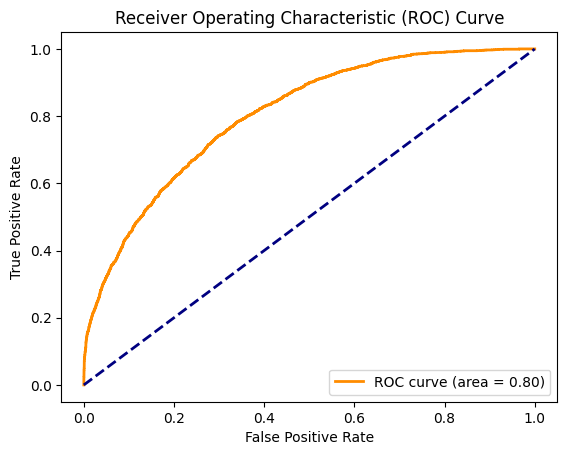

Epoch:54 | Iter:    0 | Time: 00:06:35 | Train Loss: 0.3193 | Average Loss: 0.8696 
Epoch:54 | Iter:   20 | Time: 00:06:36 | Train Loss: 0.5107 | Average Loss: 0.8688 
Epoch:54 | Iter:   40 | Time: 00:06:37 | Train Loss: 0.5894 | Average Loss: 0.8681 
Epoch:54 | Iter:   60 | Time: 00:06:38 | Train Loss: 0.3699 | Average Loss: 0.8673 
Epoch:54 | Iter:   80 | Time: 00:06:39 | Train Loss: 0.4323 | Average Loss: 0.8665 
Epoch:54 | Iter:  100 | Time: 00:06:40 | Train Loss: 0.4591 | Average Loss: 0.8657 
Epoch:54 | Iter:  120 | Time: 00:06:41 | Train Loss: 0.5247 | Average Loss: 0.8648 
Accuracy: 0.5915


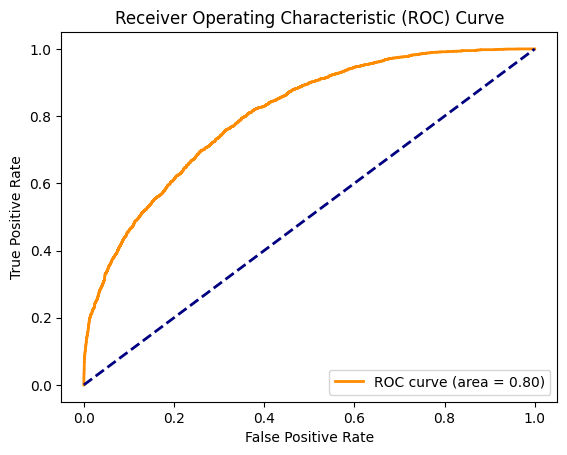

Epoch:55 | Iter:    0 | Time: 00:06:43 | Train Loss: 0.6211 | Average Loss: 0.8641 
Epoch:55 | Iter:   20 | Time: 00:06:44 | Train Loss: 0.6024 | Average Loss: 0.8633 
Epoch:55 | Iter:   40 | Time: 00:06:45 | Train Loss: 0.4474 | Average Loss: 0.8625 
Epoch:55 | Iter:   60 | Time: 00:06:46 | Train Loss: 0.5430 | Average Loss: 0.8617 
Epoch:55 | Iter:   80 | Time: 00:06:47 | Train Loss: 0.6543 | Average Loss: 0.8608 
Epoch:55 | Iter:  100 | Time: 00:06:48 | Train Loss: 0.7109 | Average Loss: 0.8600 
Epoch:55 | Iter:  120 | Time: 00:06:49 | Train Loss: 0.6128 | Average Loss: 0.8593 
Accuracy: 0.5960


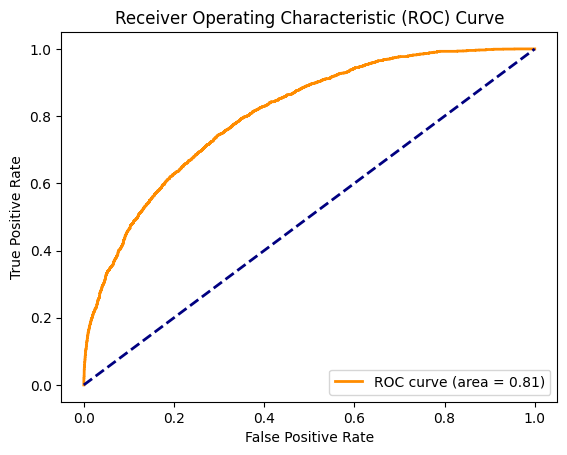

Epoch:56 | Iter:    0 | Time: 00:06:50 | Train Loss: 0.6488 | Average Loss: 0.8586 
Epoch:56 | Iter:   20 | Time: 00:06:51 | Train Loss: 0.6737 | Average Loss: 0.8579 
Epoch:56 | Iter:   40 | Time: 00:06:52 | Train Loss: 0.5339 | Average Loss: 0.8571 
Epoch:56 | Iter:   60 | Time: 00:06:53 | Train Loss: 0.4798 | Average Loss: 0.8563 
Epoch:56 | Iter:   80 | Time: 00:06:54 | Train Loss: 0.6304 | Average Loss: 0.8555 
Epoch:56 | Iter:  100 | Time: 00:06:55 | Train Loss: 0.3879 | Average Loss: 0.8546 
Epoch:56 | Iter:  120 | Time: 00:06:56 | Train Loss: 0.7442 | Average Loss: 0.8538 
Accuracy: 0.5951


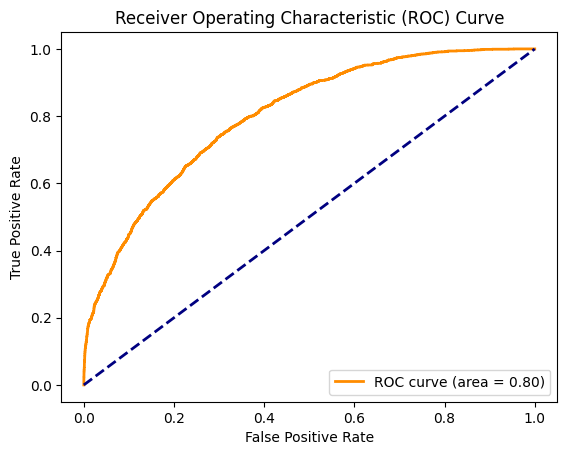

Epoch:57 | Iter:    0 | Time: 00:06:58 | Train Loss: 0.6229 | Average Loss: 0.8532 
Epoch:57 | Iter:   20 | Time: 00:06:59 | Train Loss: 0.5388 | Average Loss: 0.8525 
Epoch:57 | Iter:   40 | Time: 00:07:00 | Train Loss: 0.3935 | Average Loss: 0.8517 
Epoch:57 | Iter:   60 | Time: 00:07:01 | Train Loss: 0.3644 | Average Loss: 0.8509 
Epoch:57 | Iter:   80 | Time: 00:07:02 | Train Loss: 0.4238 | Average Loss: 0.8501 
Epoch:57 | Iter:  100 | Time: 00:07:03 | Train Loss: 0.4212 | Average Loss: 0.8493 
Epoch:57 | Iter:  120 | Time: 00:07:04 | Train Loss: 0.5916 | Average Loss: 0.8485 
Accuracy: 0.6089


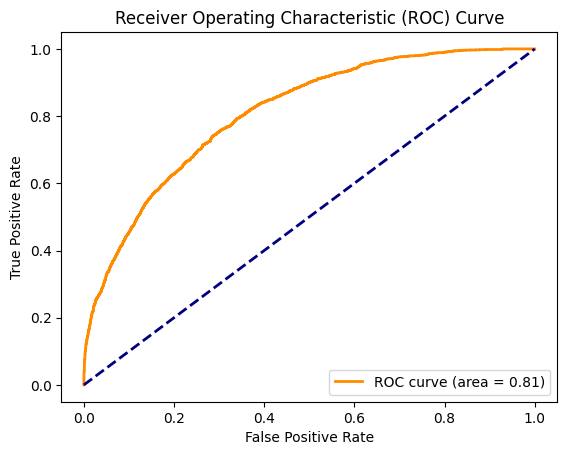

Epoch:58 | Iter:    0 | Time: 00:07:05 | Train Loss: 0.4767 | Average Loss: 0.8479 
Epoch:58 | Iter:   20 | Time: 00:07:06 | Train Loss: 0.5466 | Average Loss: 0.8471 
Epoch:58 | Iter:   40 | Time: 00:07:07 | Train Loss: 0.5241 | Average Loss: 0.8463 
Epoch:58 | Iter:   60 | Time: 00:07:08 | Train Loss: 0.3182 | Average Loss: 0.8456 
Epoch:58 | Iter:   80 | Time: 00:07:09 | Train Loss: 0.3392 | Average Loss: 0.8447 
Epoch:58 | Iter:  100 | Time: 00:07:10 | Train Loss: 0.5163 | Average Loss: 0.8439 
Epoch:58 | Iter:  120 | Time: 00:07:11 | Train Loss: 0.7146 | Average Loss: 0.8431 
Accuracy: 0.6045


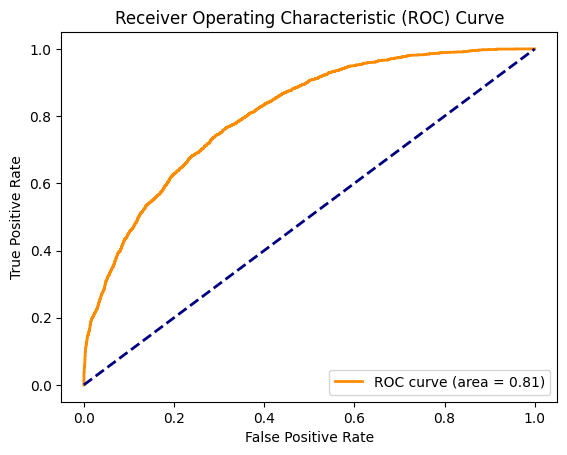

Epoch:59 | Iter:    0 | Time: 00:07:13 | Train Loss: 0.4755 | Average Loss: 0.8424 
Epoch:59 | Iter:   20 | Time: 00:07:14 | Train Loss: 0.4989 | Average Loss: 0.8416 
Epoch:59 | Iter:   40 | Time: 00:07:15 | Train Loss: 0.4953 | Average Loss: 0.8408 
Epoch:59 | Iter:   60 | Time: 00:07:16 | Train Loss: 0.5465 | Average Loss: 0.8400 
Epoch:59 | Iter:   80 | Time: 00:07:17 | Train Loss: 0.4879 | Average Loss: 0.8391 
Epoch:59 | Iter:  100 | Time: 00:07:18 | Train Loss: 0.5430 | Average Loss: 0.8384 
Epoch:59 | Iter:  120 | Time: 00:07:18 | Train Loss: 0.4955 | Average Loss: 0.8376 
Accuracy: 0.6067


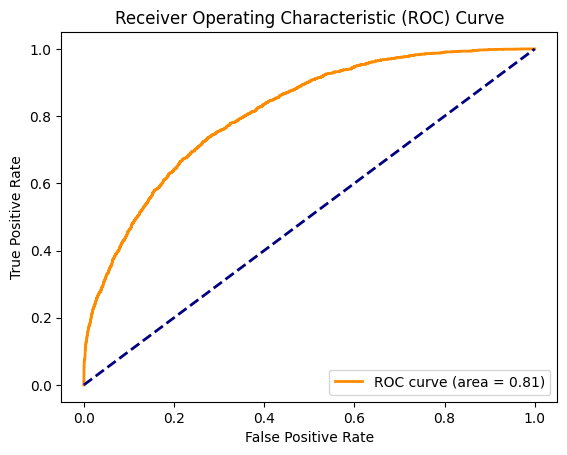

Epoch:60 | Iter:    0 | Time: 00:07:20 | Train Loss: 0.2980 | Average Loss: 0.8370 
Epoch:60 | Iter:   20 | Time: 00:07:21 | Train Loss: 0.4448 | Average Loss: 0.8363 
Epoch:60 | Iter:   40 | Time: 00:07:22 | Train Loss: 0.4358 | Average Loss: 0.8355 
Epoch:60 | Iter:   60 | Time: 00:07:23 | Train Loss: 0.5507 | Average Loss: 0.8348 
Epoch:60 | Iter:  100 | Time: 00:07:25 | Train Loss: 0.4719 | Average Loss: 0.8332 
Epoch:60 | Iter:  120 | Time: 00:07:26 | Train Loss: 0.4705 | Average Loss: 0.8325 
Accuracy: 0.6000


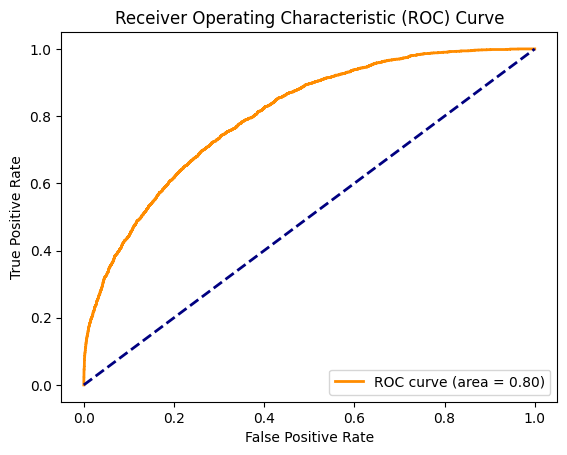

Epoch:61 | Iter:    0 | Time: 00:07:28 | Train Loss: 0.3213 | Average Loss: 0.8319 
Epoch:61 | Iter:   20 | Time: 00:07:29 | Train Loss: 0.5664 | Average Loss: 0.8312 
Epoch:61 | Iter:   40 | Time: 00:07:29 | Train Loss: 0.5419 | Average Loss: 0.8305 
Epoch:61 | Iter:   60 | Time: 00:07:30 | Train Loss: 0.3904 | Average Loss: 0.8297 
Epoch:61 | Iter:   80 | Time: 00:07:31 | Train Loss: 0.5353 | Average Loss: 0.8289 
Epoch:61 | Iter:  100 | Time: 00:07:32 | Train Loss: 0.4171 | Average Loss: 0.8280 
Epoch:61 | Iter:  120 | Time: 00:07:33 | Train Loss: 0.5882 | Average Loss: 0.8272 
Accuracy: 0.6098


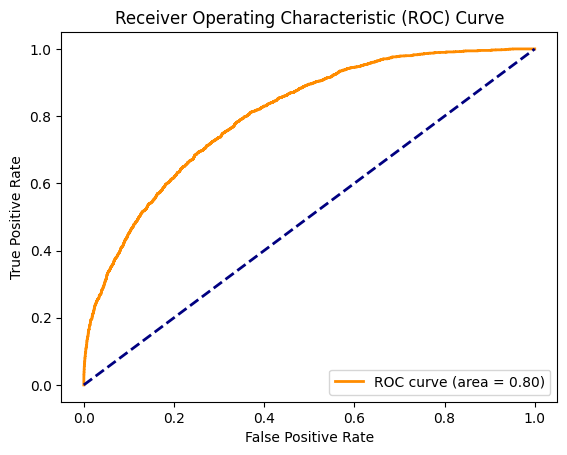

Epoch:62 | Iter:    0 | Time: 00:07:35 | Train Loss: 0.5263 | Average Loss: 0.8267 
Epoch:62 | Iter:   20 | Time: 00:07:36 | Train Loss: 0.6109 | Average Loss: 0.8260 
Epoch:62 | Iter:   40 | Time: 00:07:37 | Train Loss: 0.4493 | Average Loss: 0.8253 
Epoch:62 | Iter:   60 | Time: 00:07:38 | Train Loss: 0.4482 | Average Loss: 0.8247 
Epoch:62 | Iter:   80 | Time: 00:07:39 | Train Loss: 0.3578 | Average Loss: 0.8239 
Epoch:62 | Iter:  100 | Time: 00:07:40 | Train Loss: 0.4905 | Average Loss: 0.8230 
Epoch:62 | Iter:  120 | Time: 00:07:41 | Train Loss: 0.6045 | Average Loss: 0.8222 
Accuracy: 0.6000


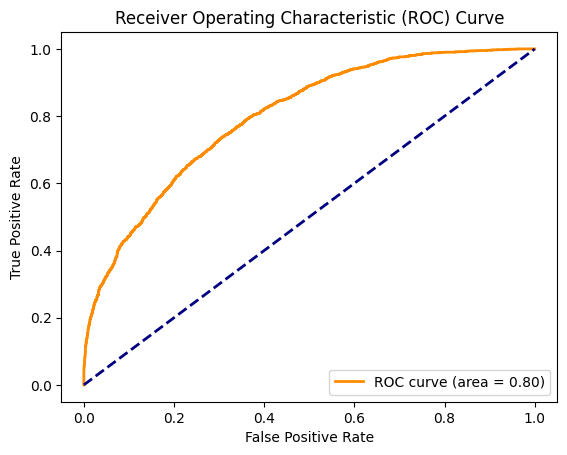

Epoch:63 | Iter:    0 | Time: 00:07:42 | Train Loss: 0.4592 | Average Loss: 0.8217 
Epoch:63 | Iter:   20 | Time: 00:07:43 | Train Loss: 0.4056 | Average Loss: 0.8209 
Epoch:63 | Iter:   40 | Time: 00:07:44 | Train Loss: 0.5375 | Average Loss: 0.8202 
Epoch:63 | Iter:   60 | Time: 00:07:45 | Train Loss: 0.3873 | Average Loss: 0.8195 
Epoch:63 | Iter:   80 | Time: 00:07:46 | Train Loss: 0.3708 | Average Loss: 0.8187 
Epoch:63 | Iter:  100 | Time: 00:07:47 | Train Loss: 0.5175 | Average Loss: 0.8180 
Epoch:63 | Iter:  120 | Time: 00:07:48 | Train Loss: 0.6280 | Average Loss: 0.8171 
Accuracy: 0.5978


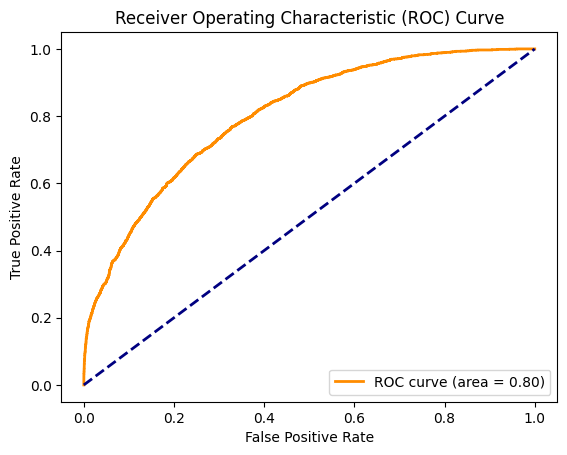

Epoch:64 | Iter:    0 | Time: 00:07:50 | Train Loss: 0.3857 | Average Loss: 0.8166 
Epoch:64 | Iter:   20 | Time: 00:07:51 | Train Loss: 0.4974 | Average Loss: 0.8158 
Epoch:64 | Iter:   40 | Time: 00:07:52 | Train Loss: 0.5036 | Average Loss: 0.8151 
Epoch:64 | Iter:   60 | Time: 00:07:53 | Train Loss: 0.4374 | Average Loss: 0.8143 
Epoch:64 | Iter:   80 | Time: 00:07:54 | Train Loss: 0.4176 | Average Loss: 0.8135 
Epoch:64 | Iter:  100 | Time: 00:07:55 | Train Loss: 0.4101 | Average Loss: 0.8127 
Epoch:64 | Iter:  120 | Time: 00:07:56 | Train Loss: 0.6695 | Average Loss: 0.8120 
Accuracy: 0.5897


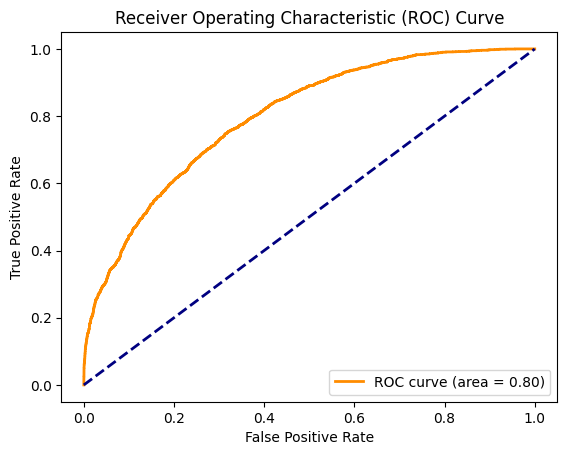

Epoch:65 | Iter:    0 | Time: 00:07:57 | Train Loss: 0.4271 | Average Loss: 0.8114 
Epoch:65 | Iter:   20 | Time: 00:07:58 | Train Loss: 0.4102 | Average Loss: 0.8107 
Epoch:65 | Iter:   40 | Time: 00:07:59 | Train Loss: 0.3933 | Average Loss: 0.8100 
Epoch:65 | Iter:   60 | Time: 00:08:00 | Train Loss: 0.5304 | Average Loss: 0.8093 
Epoch:65 | Iter:   80 | Time: 00:08:01 | Train Loss: 0.3562 | Average Loss: 0.8084 
Epoch:65 | Iter:  100 | Time: 00:08:02 | Train Loss: 0.6426 | Average Loss: 0.8076 
Epoch:65 | Iter:  120 | Time: 00:08:03 | Train Loss: 0.4258 | Average Loss: 0.8069 
Accuracy: 0.5964


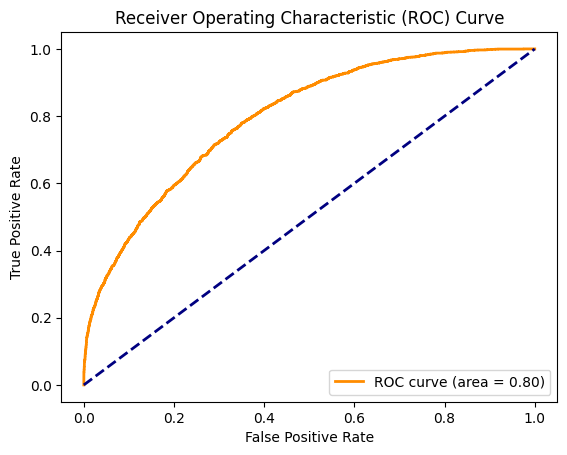

Epoch:66 | Iter:    0 | Time: 00:08:05 | Train Loss: 0.3840 | Average Loss: 0.8063 
Epoch:66 | Iter:   20 | Time: 00:08:06 | Train Loss: 0.3198 | Average Loss: 0.8057 
Epoch:66 | Iter:   40 | Time: 00:08:07 | Train Loss: 0.3595 | Average Loss: 0.8050 
Epoch:66 | Iter:   60 | Time: 00:08:08 | Train Loss: 0.5141 | Average Loss: 0.8043 
Epoch:66 | Iter:   80 | Time: 00:08:09 | Train Loss: 0.4292 | Average Loss: 0.8036 
Epoch:66 | Iter:  100 | Time: 00:08:10 | Train Loss: 0.6019 | Average Loss: 0.8029 
Epoch:66 | Iter:  120 | Time: 00:08:11 | Train Loss: 0.4891 | Average Loss: 0.8021 
Accuracy: 0.5946


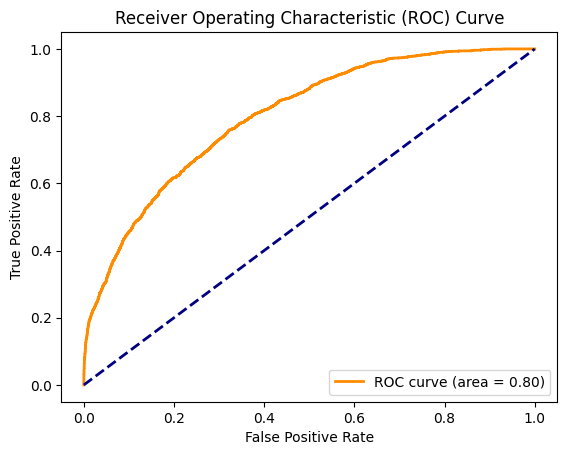

Epoch:67 | Iter:    0 | Time: 00:08:12 | Train Loss: 0.3543 | Average Loss: 0.8016 
Epoch:67 | Iter:   20 | Time: 00:08:13 | Train Loss: 0.4351 | Average Loss: 0.8008 
Epoch:67 | Iter:   40 | Time: 00:08:14 | Train Loss: 0.3592 | Average Loss: 0.8002 
Epoch:67 | Iter:   60 | Time: 00:08:15 | Train Loss: 0.4177 | Average Loss: 0.7994 
Epoch:67 | Iter:   80 | Time: 00:08:16 | Train Loss: 0.5169 | Average Loss: 0.7987 
Epoch:67 | Iter:  100 | Time: 00:08:17 | Train Loss: 0.5223 | Average Loss: 0.7980 
Epoch:67 | Iter:  120 | Time: 00:08:18 | Train Loss: 0.4184 | Average Loss: 0.7973 
Accuracy: 0.5991


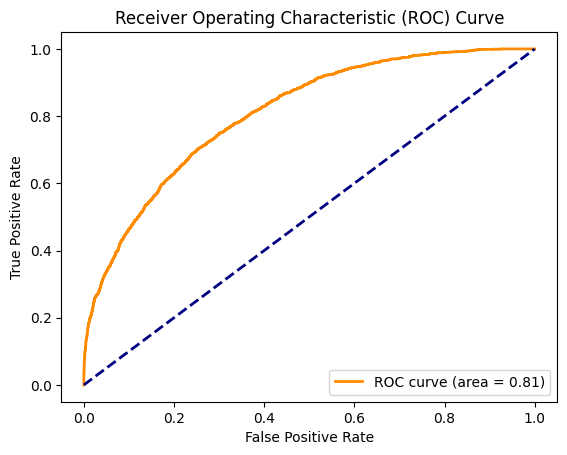

Epoch:68 | Iter:    0 | Time: 00:08:20 | Train Loss: 0.3371 | Average Loss: 0.7967 
Epoch:68 | Iter:   20 | Time: 00:08:21 | Train Loss: 0.7179 | Average Loss: 0.7960 
Epoch:68 | Iter:   40 | Time: 00:08:22 | Train Loss: 0.3017 | Average Loss: 0.7952 
Epoch:68 | Iter:   60 | Time: 00:08:23 | Train Loss: 0.3696 | Average Loss: 0.7945 
Epoch:68 | Iter:   80 | Time: 00:08:24 | Train Loss: 0.4851 | Average Loss: 0.7937 
Epoch:68 | Iter:  100 | Time: 00:08:25 | Train Loss: 0.3170 | Average Loss: 0.7929 
Epoch:68 | Iter:  120 | Time: 00:08:26 | Train Loss: 0.6197 | Average Loss: 0.7923 
Accuracy: 0.6080


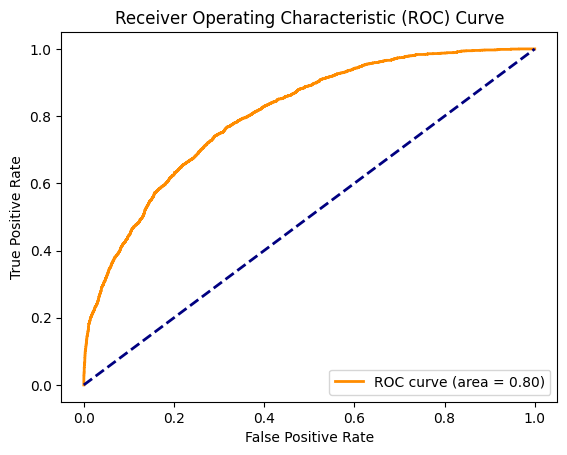

Epoch:69 | Iter:    0 | Time: 00:08:27 | Train Loss: 0.3756 | Average Loss: 0.7918 
Epoch:69 | Iter:   20 | Time: 00:08:28 | Train Loss: 0.4167 | Average Loss: 0.7911 
Epoch:69 | Iter:   40 | Time: 00:08:29 | Train Loss: 0.4640 | Average Loss: 0.7904 
Epoch:69 | Iter:   60 | Time: 00:08:30 | Train Loss: 0.4960 | Average Loss: 0.7897 
Epoch:69 | Iter:   80 | Time: 00:08:31 | Train Loss: 0.4922 | Average Loss: 0.7890 
Epoch:69 | Iter:  100 | Time: 00:08:32 | Train Loss: 0.5194 | Average Loss: 0.7882 
Epoch:69 | Iter:  120 | Time: 00:08:33 | Train Loss: 0.7103 | Average Loss: 0.7877 
Accuracy: 0.6000


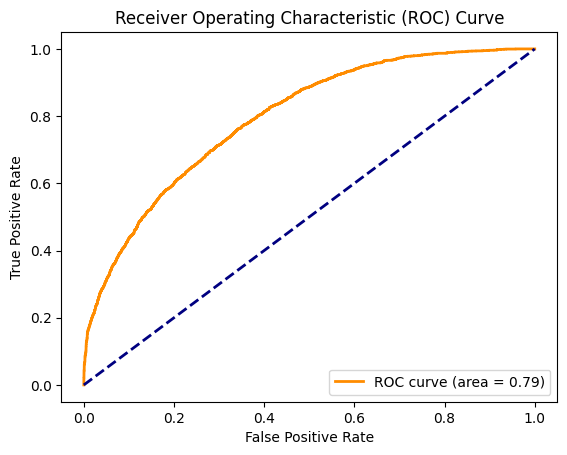

Epoch:70 | Iter:    0 | Time: 00:08:35 | Train Loss: 0.4456 | Average Loss: 0.7872 
Epoch:70 | Iter:   20 | Time: 00:08:36 | Train Loss: 0.4161 | Average Loss: 0.7865 
Epoch:70 | Iter:   40 | Time: 00:08:37 | Train Loss: 0.3755 | Average Loss: 0.7857 
Epoch:70 | Iter:   60 | Time: 00:08:38 | Train Loss: 0.4318 | Average Loss: 0.7850 
Epoch:70 | Iter:   80 | Time: 00:08:39 | Train Loss: 0.3506 | Average Loss: 0.7842 
Epoch:70 | Iter:  100 | Time: 00:08:40 | Train Loss: 0.5676 | Average Loss: 0.7836 
Epoch:70 | Iter:  120 | Time: 00:08:41 | Train Loss: 0.4666 | Average Loss: 0.7829 
Accuracy: 0.5973


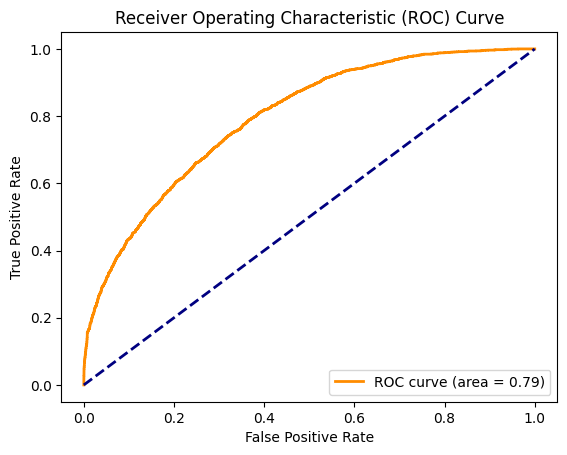

Epoch:71 | Iter:    0 | Time: 00:08:42 | Train Loss: 0.3699 | Average Loss: 0.7824 
Epoch:71 | Iter:   20 | Time: 00:08:43 | Train Loss: 0.4186 | Average Loss: 0.7817 
Epoch:71 | Iter:   40 | Time: 00:08:44 | Train Loss: 0.4193 | Average Loss: 0.7811 
Epoch:71 | Iter:   60 | Time: 00:08:45 | Train Loss: 0.4482 | Average Loss: 0.7804 
Epoch:71 | Iter:   80 | Time: 00:08:46 | Train Loss: 0.3634 | Average Loss: 0.7796 
Epoch:71 | Iter:  100 | Time: 00:08:47 | Train Loss: 0.3663 | Average Loss: 0.7789 
Epoch:71 | Iter:  120 | Time: 00:08:48 | Train Loss: 0.4111 | Average Loss: 0.7782 
Accuracy: 0.5924


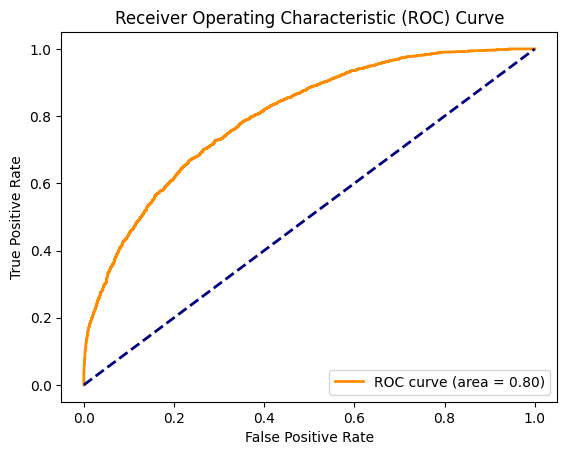

Epoch:72 | Iter:    0 | Time: 00:08:50 | Train Loss: 0.5108 | Average Loss: 0.7777 
Epoch:72 | Iter:   20 | Time: 00:08:51 | Train Loss: 0.3956 | Average Loss: 0.7770 
Epoch:72 | Iter:   40 | Time: 00:08:52 | Train Loss: 0.4158 | Average Loss: 0.7763 
Epoch:72 | Iter:   60 | Time: 00:08:53 | Train Loss: 0.3279 | Average Loss: 0.7757 
Epoch:72 | Iter:   80 | Time: 00:08:54 | Train Loss: 0.5384 | Average Loss: 0.7750 
Epoch:72 | Iter:  100 | Time: 00:08:55 | Train Loss: 0.3501 | Average Loss: 0.7743 
Epoch:72 | Iter:  120 | Time: 00:08:56 | Train Loss: 0.4332 | Average Loss: 0.7737 
Accuracy: 0.5982


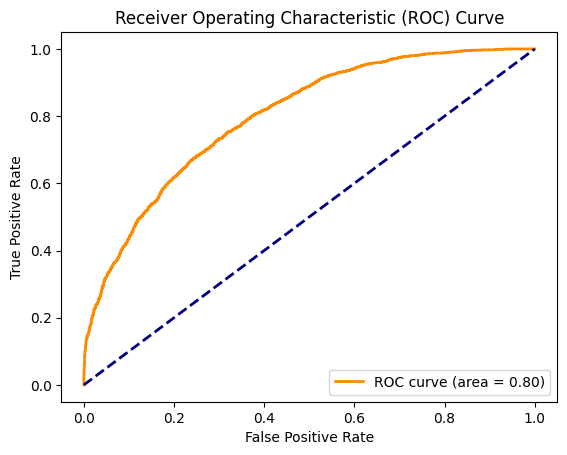

Epoch:73 | Iter:    0 | Time: 00:08:57 | Train Loss: 0.3829 | Average Loss: 0.7731 
Epoch:73 | Iter:   20 | Time: 00:08:58 | Train Loss: 0.5281 | Average Loss: 0.7725 
Epoch:73 | Iter:   40 | Time: 00:08:59 | Train Loss: 0.4374 | Average Loss: 0.7719 
Epoch:73 | Iter:   60 | Time: 00:09:00 | Train Loss: 0.3769 | Average Loss: 0.7712 
Epoch:73 | Iter:   80 | Time: 00:09:01 | Train Loss: 0.4816 | Average Loss: 0.7705 
Epoch:73 | Iter:  100 | Time: 00:09:02 | Train Loss: 0.3501 | Average Loss: 0.7699 
Epoch:73 | Iter:  120 | Time: 00:09:03 | Train Loss: 0.3855 | Average Loss: 0.7691 
Accuracy: 0.5991


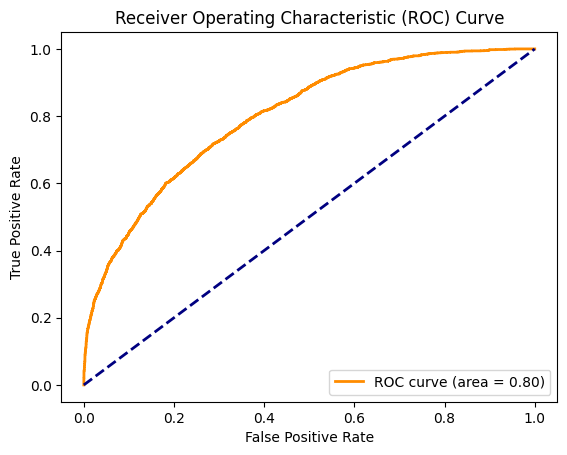

Epoch:74 | Iter:    0 | Time: 00:09:05 | Train Loss: 0.3595 | Average Loss: 0.7686 
Epoch:74 | Iter:   20 | Time: 00:09:06 | Train Loss: 0.4270 | Average Loss: 0.7680 
Epoch:74 | Iter:   40 | Time: 00:09:07 | Train Loss: 0.3969 | Average Loss: 0.7673 
Epoch:74 | Iter:   60 | Time: 00:09:08 | Train Loss: 0.3655 | Average Loss: 0.7667 
Epoch:74 | Iter:   80 | Time: 00:09:09 | Train Loss: 0.3902 | Average Loss: 0.7660 
Epoch:74 | Iter:  100 | Time: 00:09:09 | Train Loss: 0.4908 | Average Loss: 0.7654 
Epoch:74 | Iter:  120 | Time: 00:09:10 | Train Loss: 0.5652 | Average Loss: 0.7647 
Accuracy: 0.6018


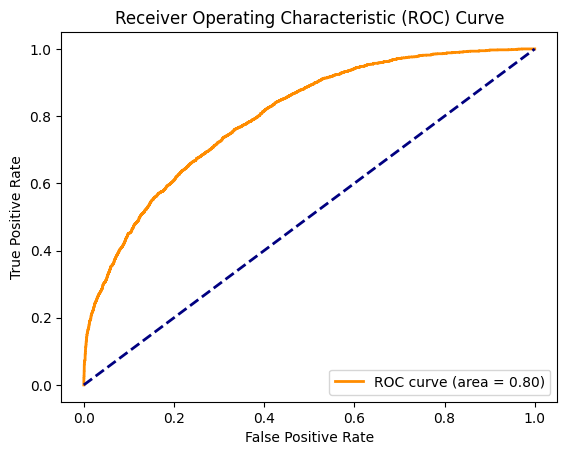

Epoch:75 | Iter:    0 | Time: 00:09:12 | Train Loss: 0.3656 | Average Loss: 0.7641 
Epoch:75 | Iter:   20 | Time: 00:09:13 | Train Loss: 0.4545 | Average Loss: 0.7635 
Epoch:75 | Iter:   40 | Time: 00:09:14 | Train Loss: 0.4363 | Average Loss: 0.7628 
Epoch:75 | Iter:   60 | Time: 00:09:15 | Train Loss: 0.2986 | Average Loss: 0.7621 
Epoch:75 | Iter:   80 | Time: 00:09:16 | Train Loss: 0.3999 | Average Loss: 0.7615 
Epoch:75 | Iter:  100 | Time: 00:09:17 | Train Loss: 0.2592 | Average Loss: 0.7608 
Epoch:75 | Iter:  120 | Time: 00:09:18 | Train Loss: 0.4828 | Average Loss: 0.7602 
Accuracy: 0.6036


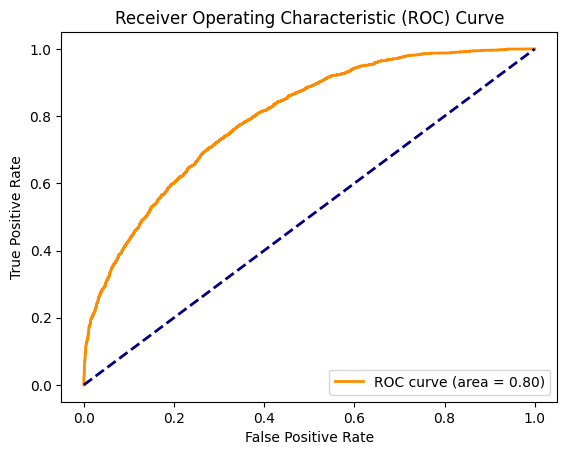

Epoch:76 | Iter:    0 | Time: 00:09:20 | Train Loss: 0.4809 | Average Loss: 0.7598 
Epoch:76 | Iter:   20 | Time: 00:09:21 | Train Loss: 0.3266 | Average Loss: 0.7591 
Epoch:76 | Iter:   40 | Time: 00:09:22 | Train Loss: 0.4665 | Average Loss: 0.7584 
Epoch:76 | Iter:   60 | Time: 00:09:23 | Train Loss: 0.3449 | Average Loss: 0.7577 
Epoch:76 | Iter:   80 | Time: 00:09:23 | Train Loss: 0.4070 | Average Loss: 0.7570 
Epoch:76 | Iter:  100 | Time: 00:09:24 | Train Loss: 0.4562 | Average Loss: 0.7563 
Epoch:76 | Iter:  120 | Time: 00:09:25 | Train Loss: 0.3795 | Average Loss: 0.7557 
Accuracy: 0.5973


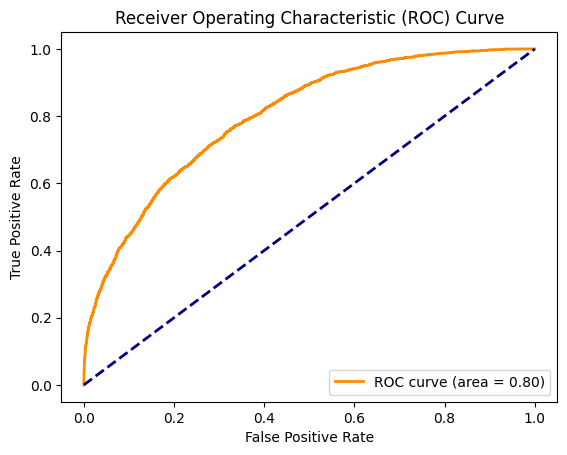

Epoch:77 | Iter:    0 | Time: 00:09:27 | Train Loss: 0.4320 | Average Loss: 0.7551 
Epoch:77 | Iter:   20 | Time: 00:09:28 | Train Loss: 0.3107 | Average Loss: 0.7545 
Epoch:77 | Iter:   40 | Time: 00:09:29 | Train Loss: 0.4080 | Average Loss: 0.7538 
Epoch:77 | Iter:   60 | Time: 00:09:30 | Train Loss: 0.5238 | Average Loss: 0.7532 
Epoch:77 | Iter:   80 | Time: 00:09:31 | Train Loss: 0.3299 | Average Loss: 0.7526 
Epoch:77 | Iter:  100 | Time: 00:09:32 | Train Loss: 0.5218 | Average Loss: 0.7519 
Epoch:77 | Iter:  120 | Time: 00:09:33 | Train Loss: 0.4527 | Average Loss: 0.7512 
Accuracy: 0.6018


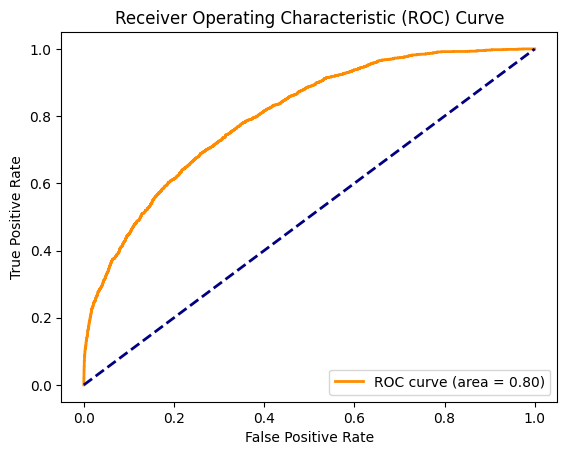

Epoch:78 | Iter:    0 | Time: 00:09:35 | Train Loss: 0.3051 | Average Loss: 0.7507 
Epoch:78 | Iter:   20 | Time: 00:09:36 | Train Loss: 0.3467 | Average Loss: 0.7500 
Epoch:78 | Iter:   40 | Time: 00:09:37 | Train Loss: 0.5688 | Average Loss: 0.7495 
Epoch:78 | Iter:   60 | Time: 00:09:38 | Train Loss: 0.4870 | Average Loss: 0.7488 
Epoch:78 | Iter:   80 | Time: 00:09:38 | Train Loss: 0.3866 | Average Loss: 0.7482 
Epoch:78 | Iter:  100 | Time: 00:09:39 | Train Loss: 0.4267 | Average Loss: 0.7476 
Epoch:78 | Iter:  120 | Time: 00:09:40 | Train Loss: 0.4509 | Average Loss: 0.7470 
Accuracy: 0.6013


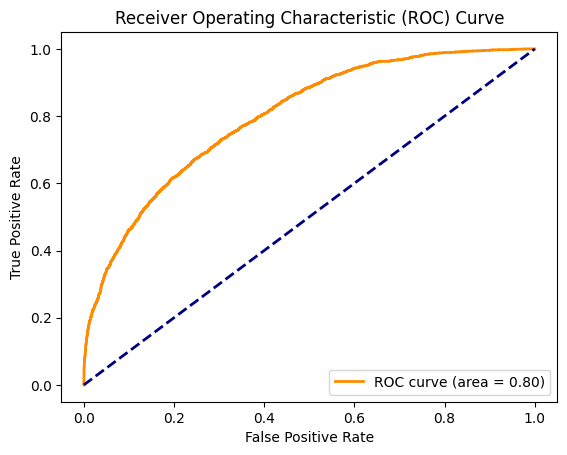

Epoch:79 | Iter:    0 | Time: 00:09:42 | Train Loss: 0.4350 | Average Loss: 0.7465 
Epoch:79 | Iter:   20 | Time: 00:09:43 | Train Loss: 0.5030 | Average Loss: 0.7458 
Epoch:79 | Iter:   40 | Time: 00:09:44 | Train Loss: 0.2797 | Average Loss: 0.7452 
Epoch:79 | Iter:   60 | Time: 00:09:45 | Train Loss: 0.4983 | Average Loss: 0.7445 
Epoch:79 | Iter:   80 | Time: 00:09:46 | Train Loss: 0.2956 | Average Loss: 0.7438 
Epoch:79 | Iter:  100 | Time: 00:09:47 | Train Loss: 0.2396 | Average Loss: 0.7431 
Epoch:79 | Iter:  120 | Time: 00:09:48 | Train Loss: 0.6022 | Average Loss: 0.7426 
Accuracy: 0.5893


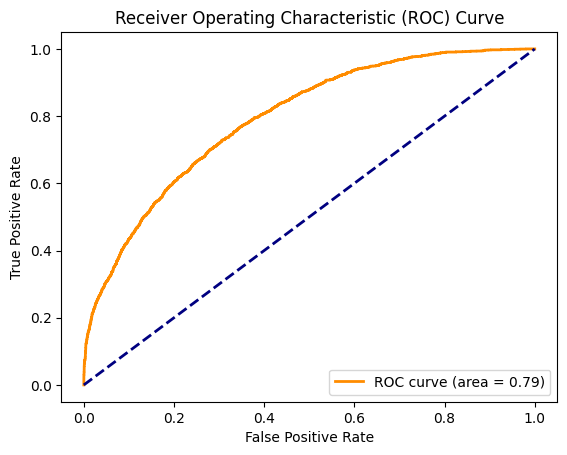

Epoch:80 | Iter:    0 | Time: 00:09:50 | Train Loss: 0.4626 | Average Loss: 0.7421 
Epoch:80 | Iter:   20 | Time: 00:09:51 | Train Loss: 0.3085 | Average Loss: 0.7414 
Epoch:80 | Iter:   40 | Time: 00:09:52 | Train Loss: 0.4356 | Average Loss: 0.7408 
Epoch:80 | Iter:   60 | Time: 00:09:53 | Train Loss: 0.4618 | Average Loss: 0.7402 
Epoch:80 | Iter:   80 | Time: 00:09:53 | Train Loss: 0.3513 | Average Loss: 0.7396 
Epoch:80 | Iter:  100 | Time: 00:09:54 | Train Loss: 0.4227 | Average Loss: 0.7391 
Epoch:80 | Iter:  120 | Time: 00:09:55 | Train Loss: 0.3297 | Average Loss: 0.7385 
Accuracy: 0.5996


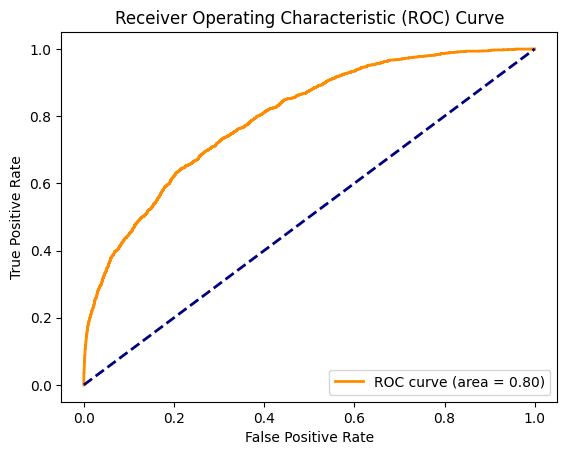

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve


# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.4)

        self.conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.dropout2 = nn.Dropout(0.4)

        self.conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.dropout3 = nn.Dropout(0.4)

        self.conv4 = nn.Conv2d(512, 512, 3, padding=1)
        self.dropout4 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.dropout5 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(512, 256)
        self.dropout6 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, len(class_names))  # Output layer with number of classes as output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.float())))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)

        x = F.relu(self.fc2(x))
        x = self.dropout6(x)

        x = self.fc3(x)
        return x

# Create an instance of the CNN model
cnn_model = CNN()

# Training options
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 80
train_option['device'] = 'gpu'

# Train the model
trainModel(cnn_model, trainloader, train_option, testloader)


In [ ]:
"""!pip install onnx onnx-tf tensorflow"""

In [ ]:
"""# Move the model to CPU device
cnn_model_cpu = cnn_model.cpu()

# Export the PyTorch model to ONNX
dummy_input = torch.randn(1, 3, 64, 64)  # Example input shape
torch.onnx.export(cnn_model_cpu, dummy_input, "cnn_model.onnx", verbose=True, input_names=['input'], output_names=['output'])"""


In [ ]:
"""import torch.onnx
import onnx
from onnx_tf.backend import prepare

# Move the model to CPU device
cnn_model_cpu = cnn_model.cpu()

# Export the PyTorch model to ONNX
dummy_input = torch.randn(1, 3, 64, 64)  # Example input shape
torch.onnx.export(cnn_model_cpu, dummy_input, "cnn_model.onnx", verbose=True, input_names=['input'], output_names=['output'])

# Load the exported ONNX model
onnx_model = onnx.load("cnn_model.onnx")

# Convert ONNX model to TensorFlow Lite
tf_rep = prepare(onnx_model)
tflite_model = tf_rep.export_graph('/content/drive/My Drive/CapstoneProject/cnn_model.tflite')"""


INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_22_x, mul_3_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to /content/drive/My Drive/CapstoneProject/cnn_model.tflite/fingerprint.pb
